# USD MSADS 505 Final Project - Team 3
# Caleb McCurdy, Jesse Gutierrez, and Jessica Hin

Importing required libraries and packages

In [1]:
import klib
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#import xgboost as xgb
# import statsmodels.api as sma


%matplotlib inline
from klib import corr_plot
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb
from sklearn.svm import SVC


from scipy.stats import yeojohnson
#import tensorflow as tf
#from tensorflow import keras

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

2023-10-11 20:52:34.792401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


This code chunk is to prevent lenghty warning messages from appearing during notebook rendering.

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


# Part 1 - EDA
## Describing the data and data information

In [3]:
# Load the bank-full spreadsheet
df = pd.read_csv('/Users/jesse/Downloads/bank+marketing/bank/bank-full.csv', delimiter= ';')
# Display the first 5 rows to preview table
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Display the dimension of the spreadsheet
df.shape

(45211, 17)

In [5]:
# Display column names
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [6]:
# Display the data types
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [7]:
# Display null values
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [8]:
# Review statistical descriptive analysis on numeric attributes
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
# Display unique outputs
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

Identifying which variables are numeric and which ones are catgorical.

In [10]:
# create subsets of the variables by type
num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# updating objects to categorical type
df[cat_vars] = df[cat_vars].astype('category') 

In [11]:
# Subset the data to only have the numeric data
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Display the header
numeric_df.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


## Visualizations the numeric variables  
### Boxplots

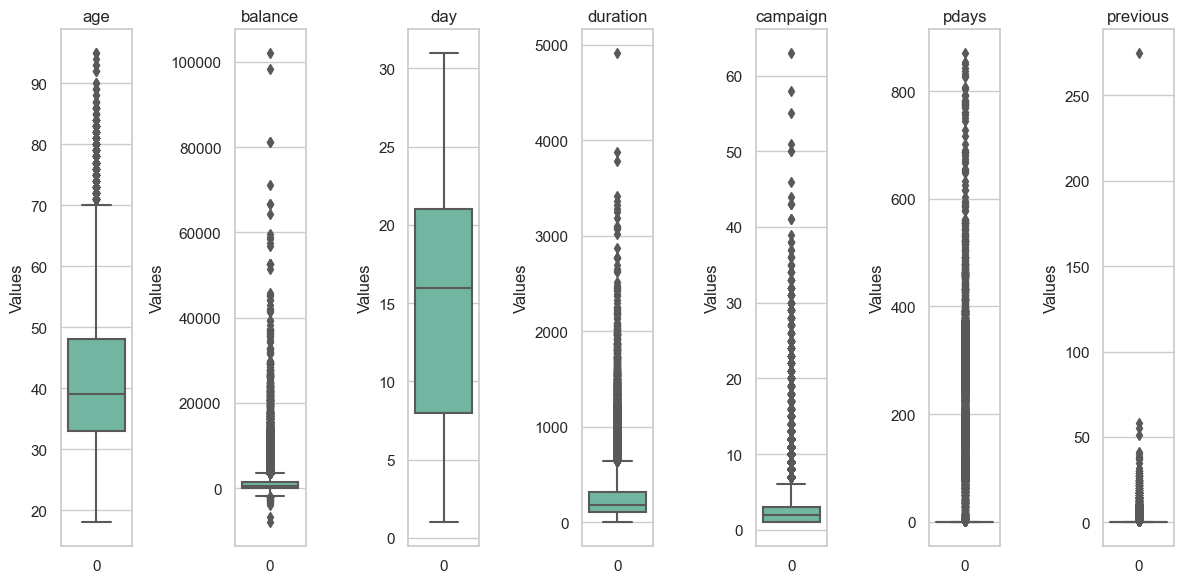

In [12]:
# Establish the style for the plots
sns.set(style="whitegrid")

# Create separate boxplots for each numeric column
plt.figure(figsize=(12, 6))

# Create a loop to generate independent subplots
for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(1, len(numeric_df.columns), i)
    sns.boxplot(data=numeric_df[col], orient="v", palette="Set2")
    plt.title(f'{col}')
    plt.ylabel('Values')
# Combine & display outputs
plt.tight_layout()
plt.show()

Through the above box plot visualization, we were able to see the distribution of values among each numeric attribute while also identifying outliers.

### Scatterplots

### Histograms

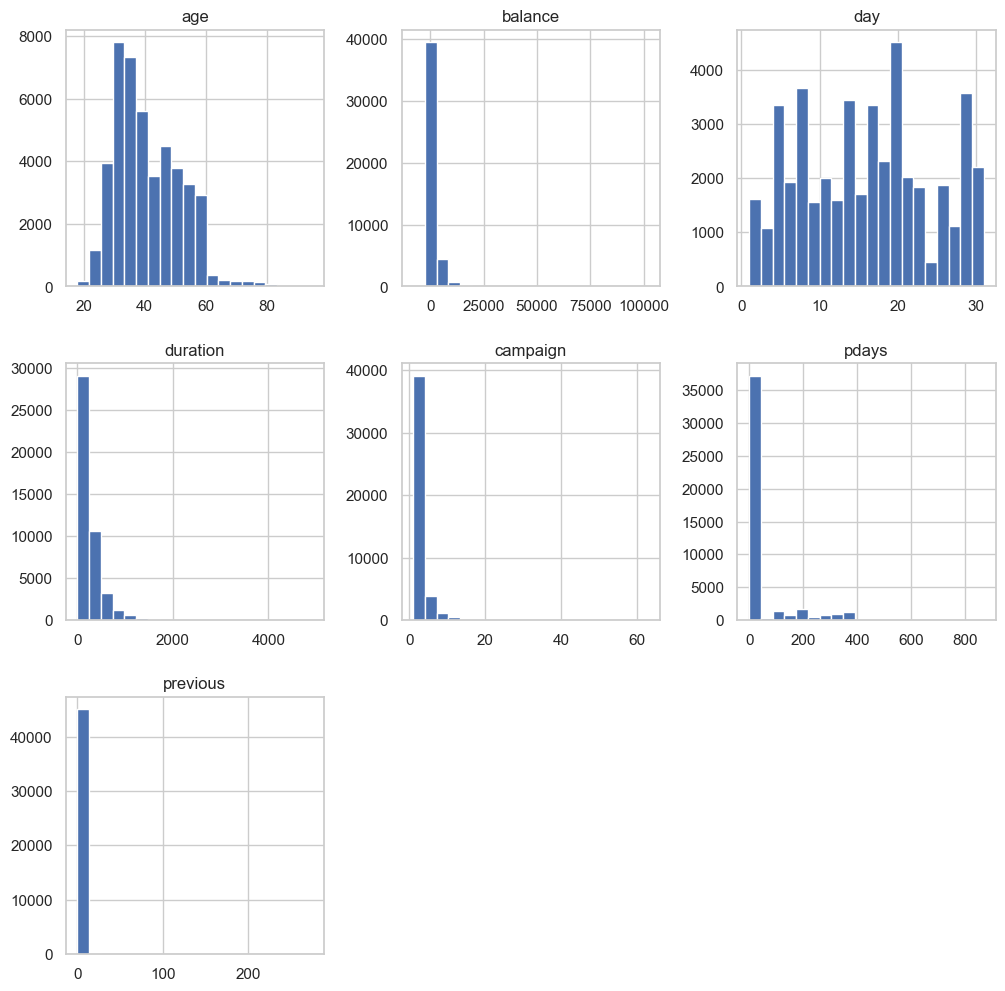

In [13]:
# Plot historgrams to assess distribution & skewness
df[num_vars].hist(figsize=(12,12),bins=20)
plt.show()

As seen in the histograms, many of the numeric attributes are skewed right.

### Correlation Plot

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

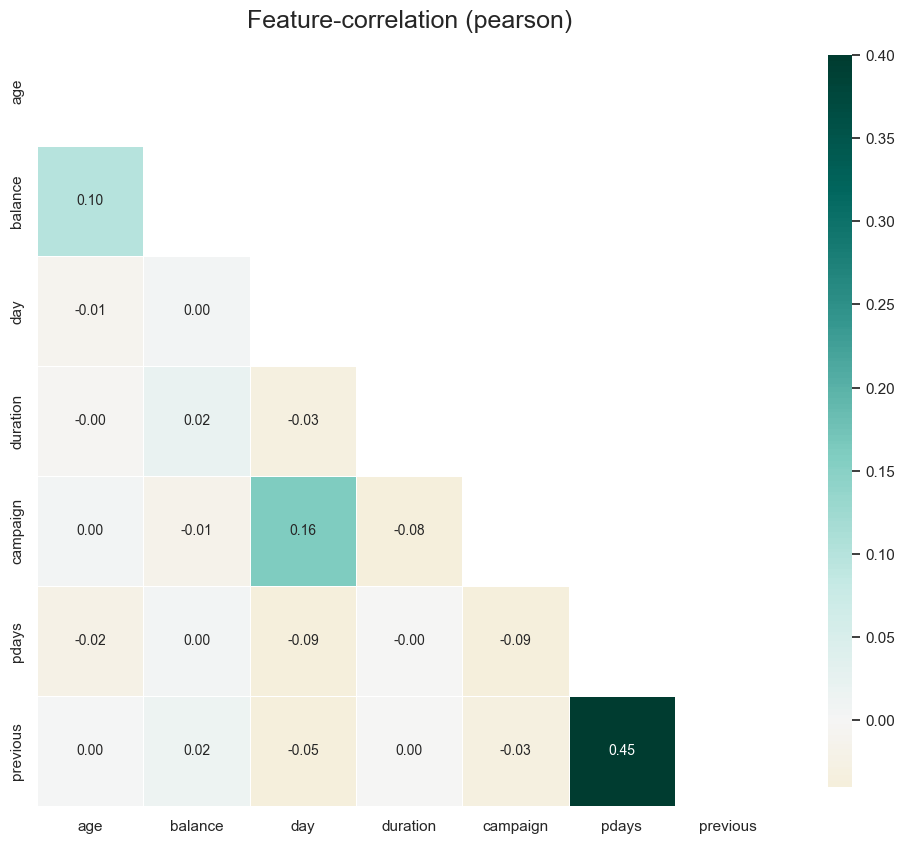

In [14]:
# Calculate correlation analysis among numeric attributes
klib.corr_plot(df[num_vars])

## Visualizations of the categorical variables  
### Histograms with respect to the response variable 'y'

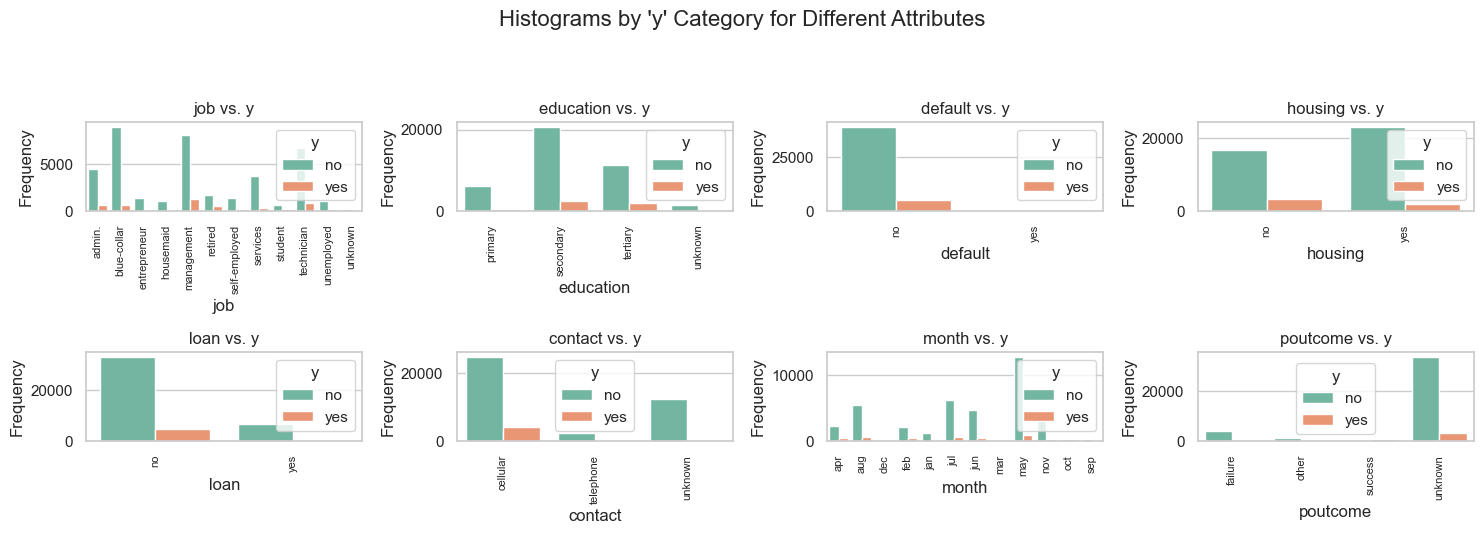

In [15]:
# Set the style for the plots (optional)
sns.set(style="whitegrid")

# List of columns to include in the grid
columns_to_compare = ['job', 'education', 'default', 'housing', 'loan', 'contact',
                      'month', 'poutcome']

# Create a grid of histograms comparing each column to 'y'
num_rows = 5
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.suptitle("Histograms by 'y' Category for Different Attributes", fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through the specified columns and create histograms for each
for i, col in enumerate(columns_to_compare):
    ax = axes[i]
    
    # Rotate x-axis labels by 45 degrees and set a smaller font size
    sns.countplot(data=df, x=col, hue='y', ax=ax, palette="Set2")
    ax.set_title(f'{col} vs. y')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
# Remove any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The grid of plots allow for a closer analysis of the distribution of observations with a yes value for 'y.' This helps us understand which type of contact, background information, and time period may potentially influence the predicted output.

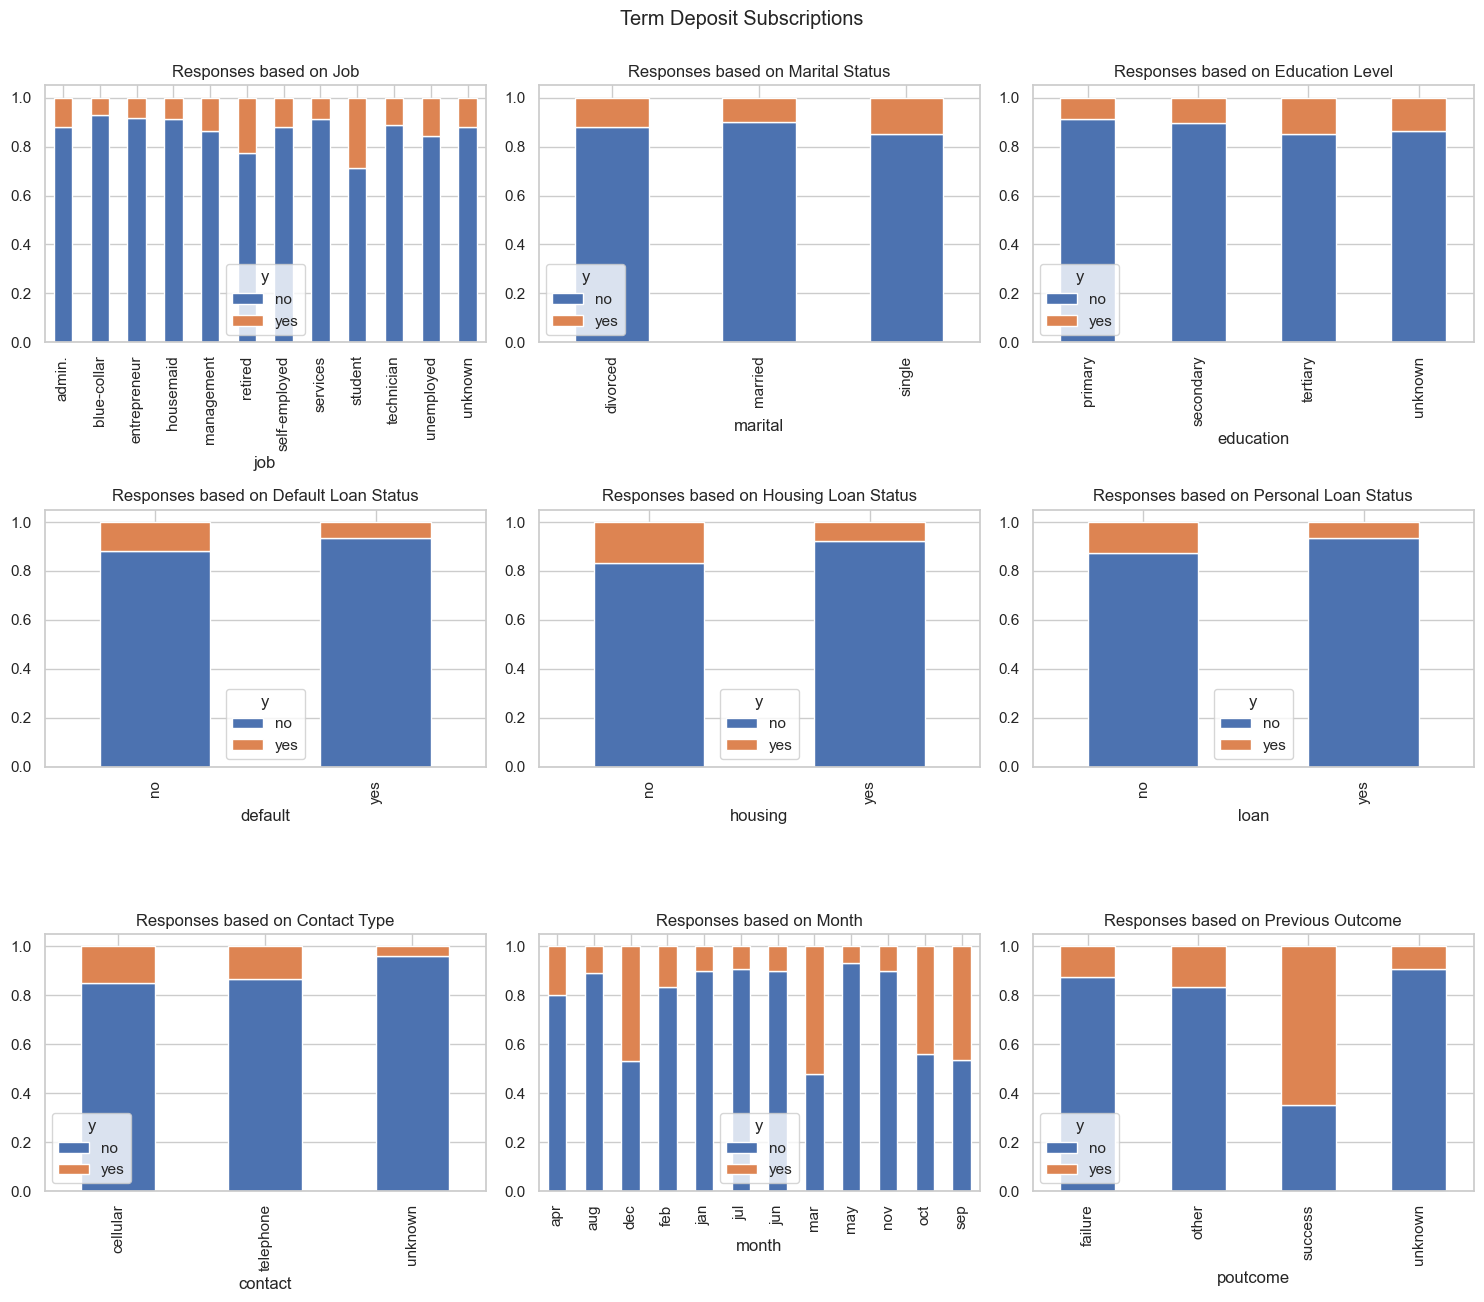

In [16]:
# Create plots comparing 'y' to independent categorical variables
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13))
fig.suptitle('Term Deposit Subscriptions', y=1)

# plotting by job
ax0 = pd.crosstab(df['job'], df['y'])
ax0 = ax0.div(ax0.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][0])
ax0.set_title('Responses based on Job')

# plotting by marital
ax1 = pd.crosstab(df['marital'], df['y'])
ax1 = ax1.div(ax1.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][1])
ax1.set_title('Responses based on Marital Status')

# plotting by education
ax2 = pd.crosstab(df['education'], df['y'])
ax2 = ax2.div(ax2.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][2])
ax2.set_title('Responses based on Education Level')

# plotting by default
ax3 = pd.crosstab(df['default'], df['y'])
ax3 = ax3.div(ax3.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][0])
ax3.set_title('Responses based on Default Loan Status')

# plotting by housing
ax4 = pd.crosstab(df['housing'], df['y'])
ax4 = ax4.div(ax4.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][1])
ax4.set_title('Responses based on Housing Loan Status')

# plotting by loan
ax5 = pd.crosstab(df['loan'], df['y'])
ax5 = ax5.div(ax5.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][2])
ax5.set_title('Responses based on Personal Loan Status')

# plotting by contact
ax6 = pd.crosstab(df['contact'], df['y'])
ax6 = ax6.div(ax6.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][0])
ax6.set_title('Responses based on Contact Type')

# plotting by month
ax7 = pd.crosstab(df['month'], df['y'])
ax7 = ax7.div(ax7.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][1])
ax7.set_title('Responses based on Month')

# plotting by poutcome
ax8 = pd.crosstab(df['poutcome'], df['y'])
ax8 = ax8.div(ax8.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][2])
ax8.set_title('Responses based on Previous Outcome')

plt.tight_layout()
plt.show()

The plots show that there is a larger relative number of students and retired that have a desired predicted output. In adddition, March and December are the months that had the largest amount of people subscribe to a term deposit.

### Boxplots of categorical variables with respect to y

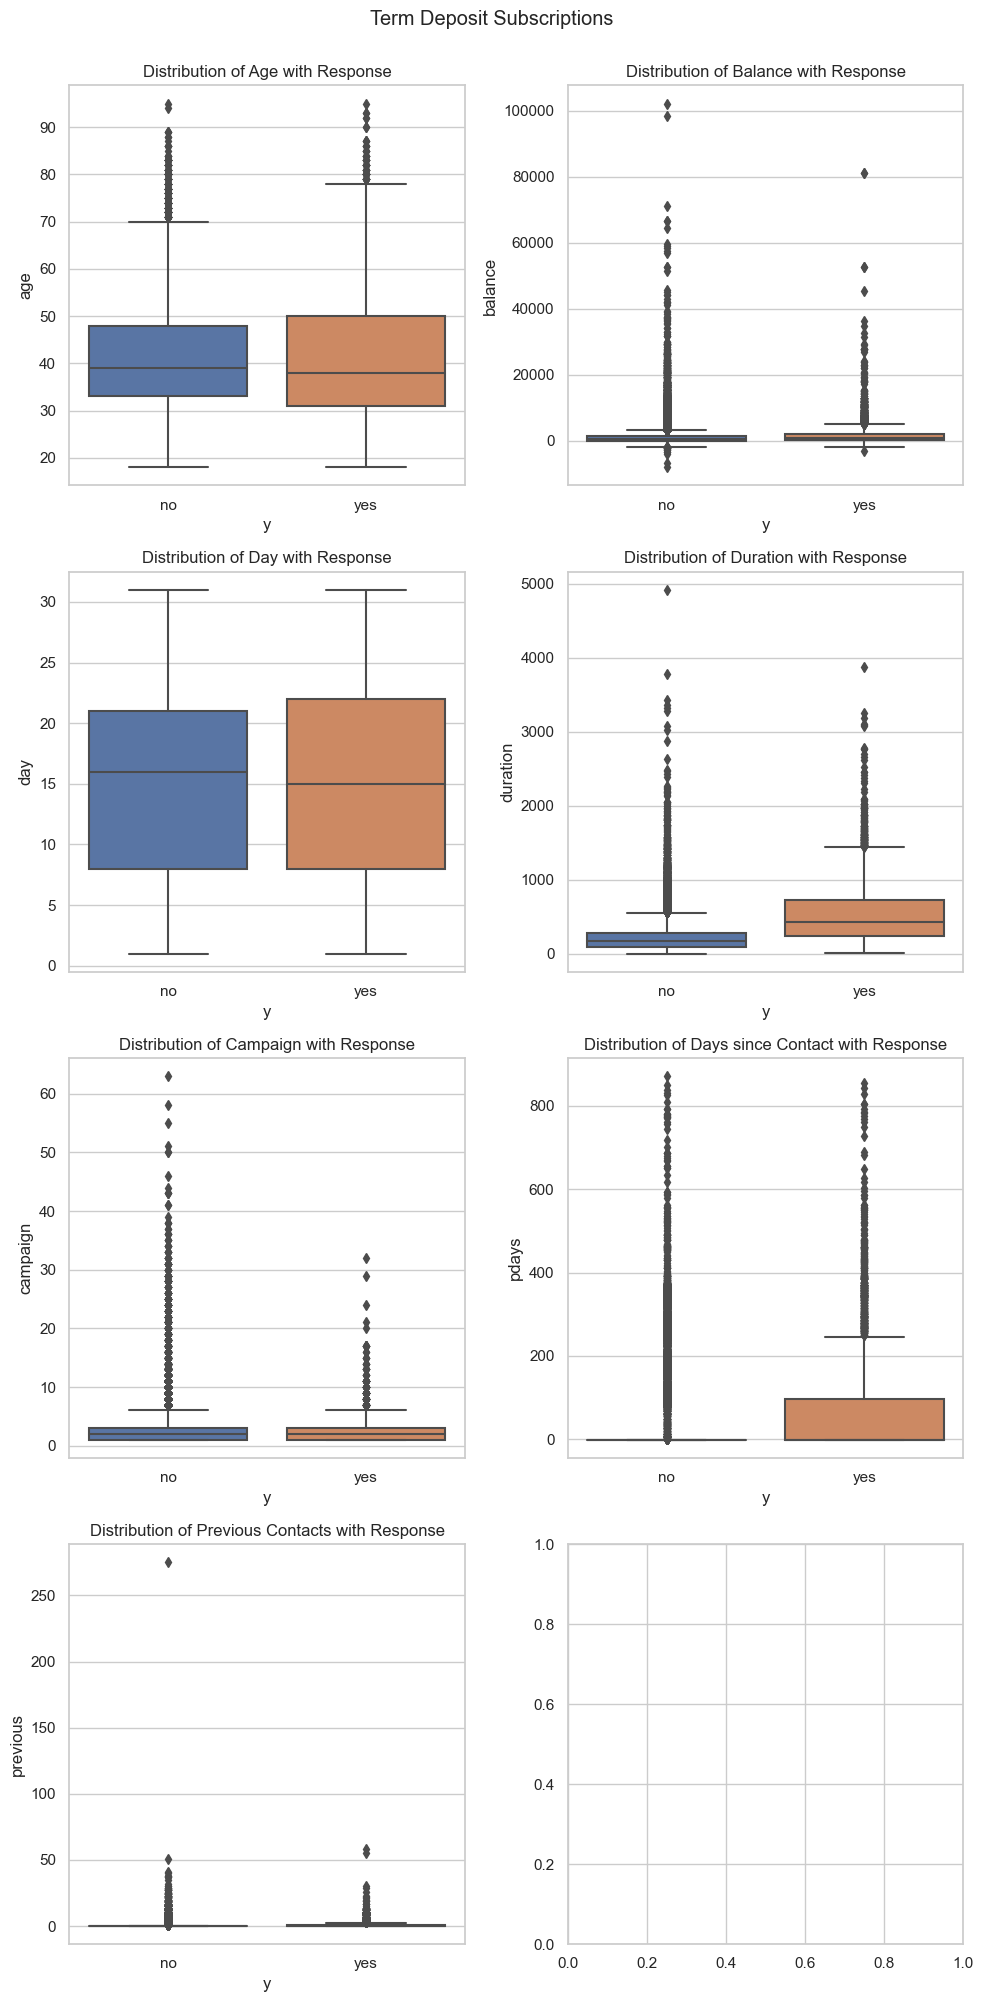

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
fig.suptitle('Term Deposit Subscriptions', y=1)

# plotting by age
ax0 = sns.boxplot(y="age", x='y', data=df, ax = axes[0][0])
ax0.set_title('Distribution of Age with Response')

# plotting by balance
ax1 = sns.boxplot(y="balance", x='y', data=df, ax = axes[0][1])
ax1.set_title('Distribution of Balance with Response')

# plotting by day
ax2 = sns.boxplot(y="day", x='y', data=df, ax = axes[1][0])
ax2.set_title('Distribution of Day with Response')

# plotting by duration
ax3 = sns.boxplot(y="duration", x='y', data=df, ax = axes[1][1])
ax3.set_title('Distribution of Duration with Response')

# plotting by campaign
ax4 = sns.boxplot(y="campaign", x='y', data=df, ax = axes[2][0])
ax4.set_title('Distribution of Campaign with Response')

# plotting by pdays
ax5 = sns.boxplot(y="pdays", x='y', data=df, ax = axes[2][1])
ax5.set_title('Distribution of Days since Contact with Response')

# plotting by previous
ax6 = sns.boxplot(y="previous", x='y', data=df, ax = axes[3][0])
ax6.set_title('Distribution of Previous Contacts with Response')

plt.tight_layout()
plt.show()

## Visualizations for the records that had 'y' = Yes

In [18]:
# Categorical columns to analyze
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'campaign', 'previous', 'poutcome']

# Varaible used to store the results
results = []

# Iterate through the categorical columns
for col in categorical_columns:
    unique_values = df[col].unique()
    for value in unique_values:
        sub_df = df[df[col] == value]
        total_count = sub_df.shape[0]  
        yes_count = sub_df[sub_df['y'] == 'yes'].shape[0]
        percentage = (yes_count / total_count) * 100 if total_count > 0 else 0.0
        results.append({'Column': col, 'Value': value, 'Percentage': percentage, 'Total Frequency': total_count})

# Save the results as a Data Frame
result_df = pd.DataFrame(results)

# Sort results in descending order
result_df = result_df.sort_values(by='Percentage', ascending=False)

# Display top 20 unique values
result_df.head(20)

,Column,Value,Percentage,Total Frequency
126,previous,55,100.000000,1
122,previous,58,100.000000,1
132,poutcome,success,64.725347,1511
37,month,mar,51.991614,477
106,previous,26,50.000000,2
34,month,dec,46.728972,214
39,month,sep,46.459413,579
32,month,oct,43.766938,738
97,previous,10,38.805970,67
121,previous,30,33.333333,3


In [19]:
# Wanted to further look at the distribution among each attribute
month_df = result_df[result_df['Column'] == 'month']
# Display table
month_df

,Column,Value,Percentage,Total Frequency
37,month,mar,51.991614,477
34,month,dec,46.728972,214
39,month,sep,46.459413,579
32,month,oct,43.766938,738
38,month,apr,19.679400,2932
36,month,feb,16.647792,2649
31,month,aug,11.013286,6247
29,month,jun,10.222805,5341
33,month,nov,10.151134,3970
35,month,jan,10.121169,1403


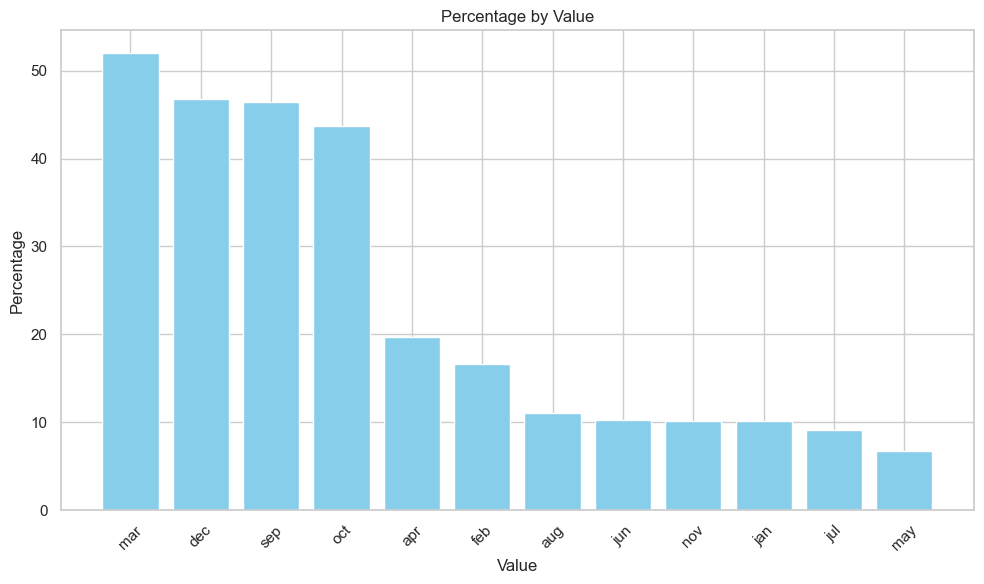

In [20]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(month_df['Value'], month_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [21]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in month_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [22]:
# Wanted to further look at the distribution among each attribute
marital_df = result_df[result_df['Column'] == 'marital']
# Display table
marital_df

,Column,Value,Percentage,Total Frequency
13,marital,single,14.949179,12790
14,marital,divorced,11.945458,5207
12,marital,married,10.123466,27214


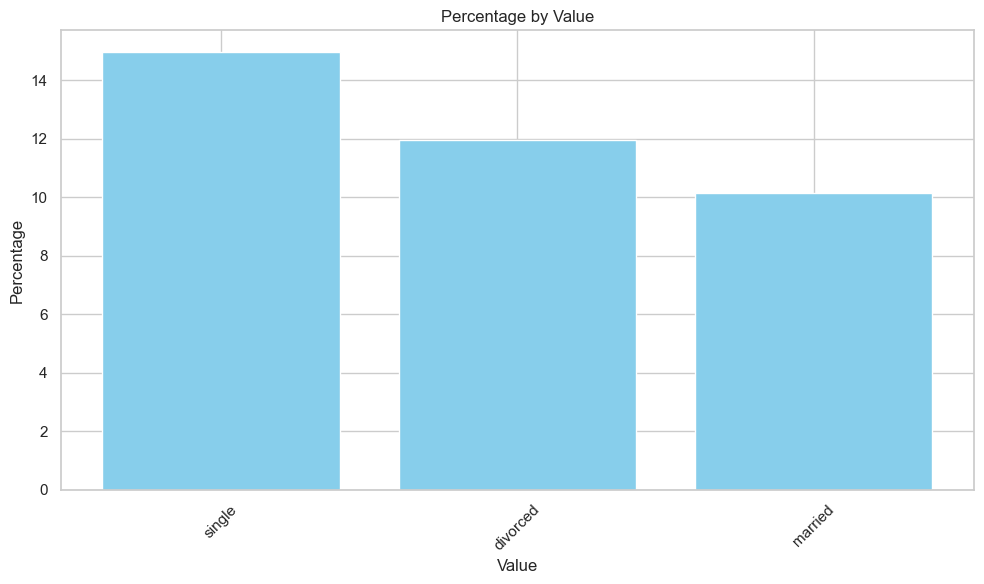

In [23]:
# Create bar plot for marital status
plt.figure(figsize=(10, 6))
plt.bar(marital_df['Value'], marital_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [24]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in marital_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [25]:
# Wanted to further look at the distribution among each attribute
job_df = result_df[result_df['Column'] == 'job']
# Display table
job_df

,Column,Value,Percentage,Total Frequency
11,job,student,28.678038,938
5,job,retired,22.791519,2264
9,job,unemployed,15.502686,1303
0,job,management,13.755551,9458
6,job,admin.,12.202669,5171
8,job,self-employed,11.842939,1579
4,job,unknown,11.805556,288
1,job,technician,11.056996,7597
7,job,services,8.883004,4154
10,job,housemaid,8.790323,1240


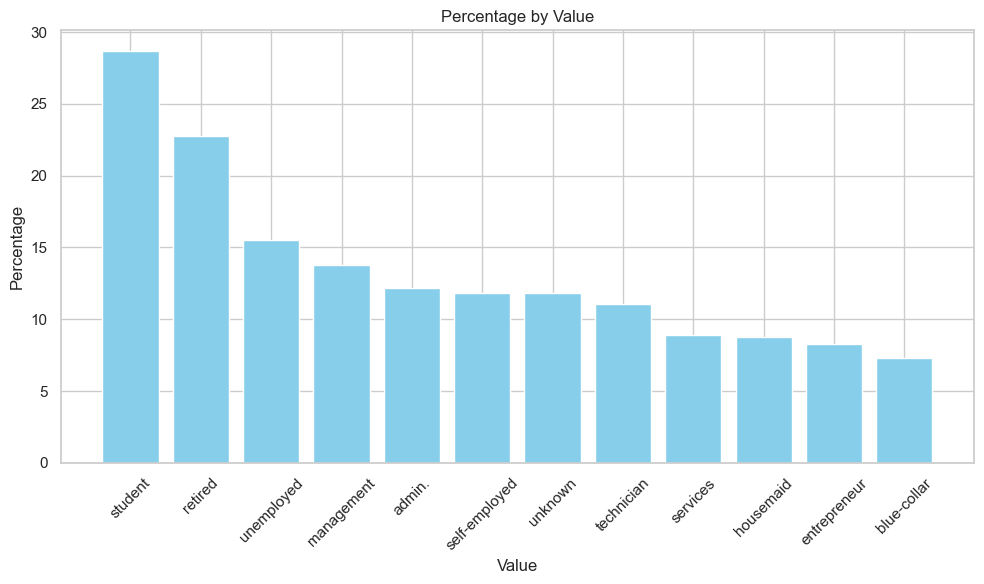

In [26]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(job_df['Value'], job_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [27]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in job_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [28]:
# Wanted to further look at the distribution among each attribute
education_df = result_df[result_df['Column'] == 'education']
# Display table
education_df

,Column,Value,Percentage,Total Frequency
15,education,tertiary,15.006390,13301
17,education,unknown,13.570275,1857
16,education,secondary,10.559435,23202
18,education,primary,8.626478,6851


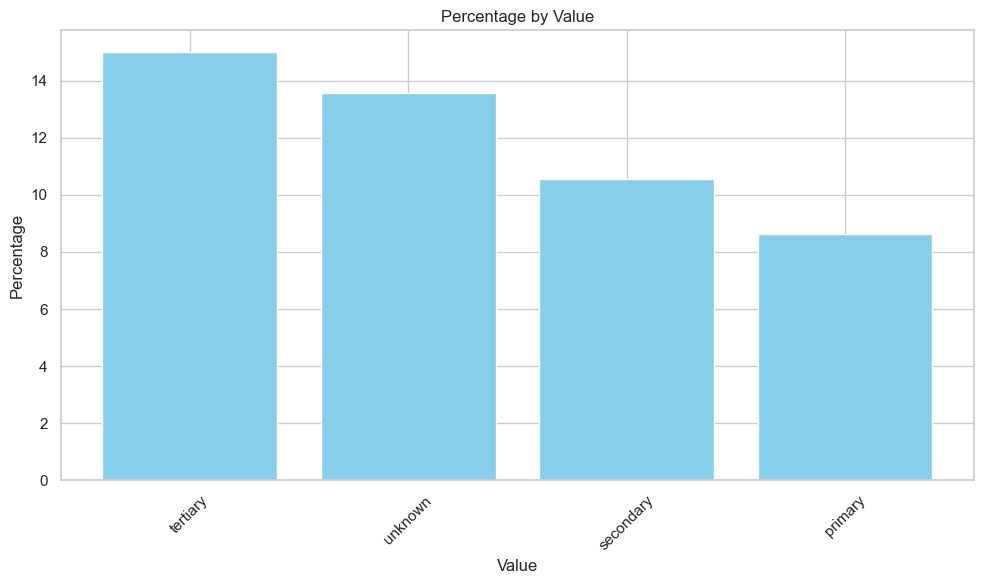

In [29]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(education_df['Value'], education_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [30]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in education_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [31]:
# Wanted to further look at the distribution among each attribute
default_df = result_df[result_df['Column'] == 'default']
# Display table
default_df

,Column,Value,Percentage,Total Frequency
19,default,no,11.796108,44396
20,default,yes,6.380368,815


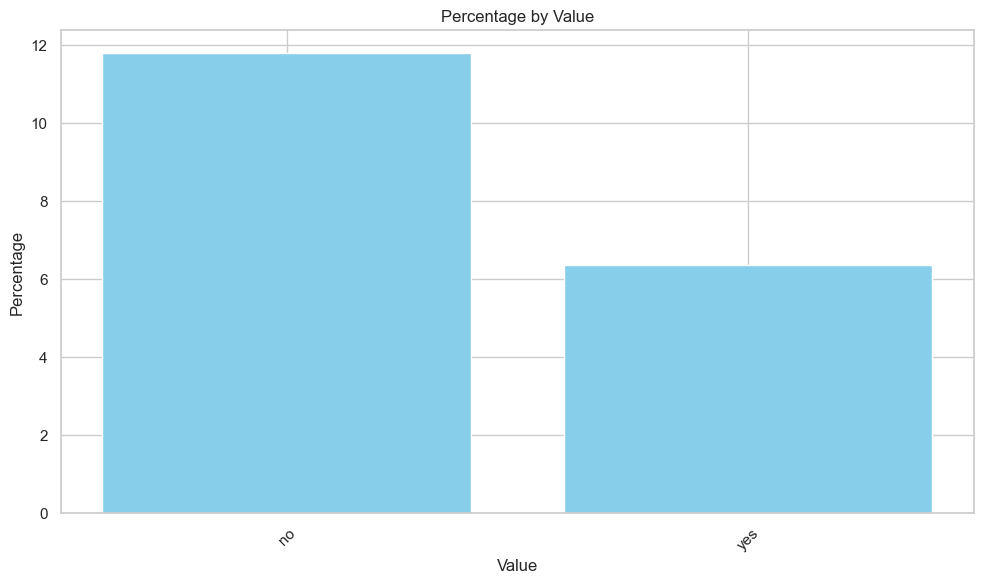

In [32]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(default_df['Value'], default_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [33]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in default_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [34]:
# Wanted to further look at the distribution among each attribute
housing_df = result_df[result_df['Column'] == 'housing']
# Display table
housing_df

,Column,Value,Percentage,Total Frequency
22,housing,no,16.702355,20081
21,housing,yes,7.699960,25130


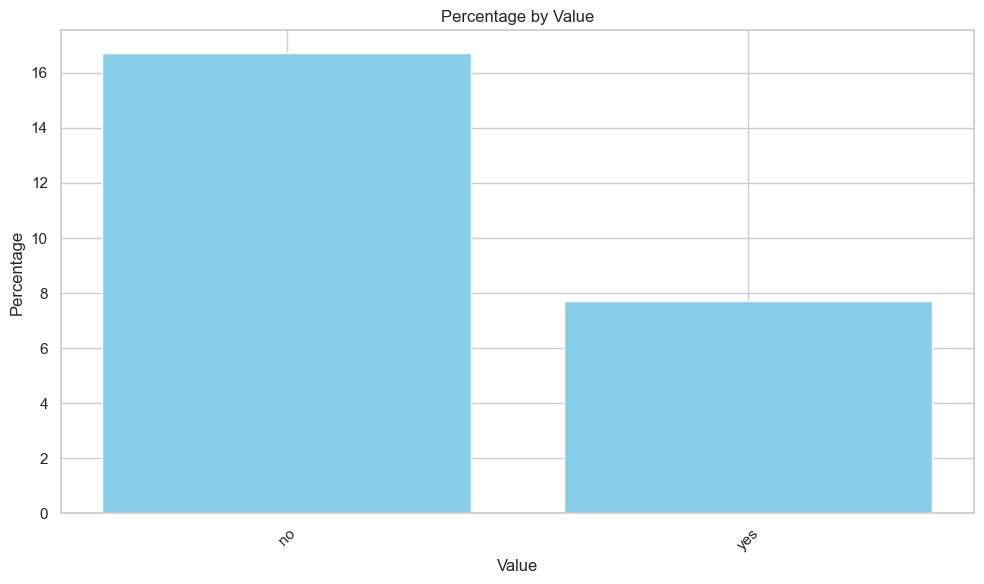

In [35]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(housing_df['Value'], housing_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [36]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in housing_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [37]:
# Wanted to further look at the distribution among each attribute
loan_df = result_df[result_df['Column'] == 'loan']
# Display table
loan_df

,Column,Value,Percentage,Total Frequency
23,loan,no,12.655727,37967
24,loan,yes,6.681391,7244


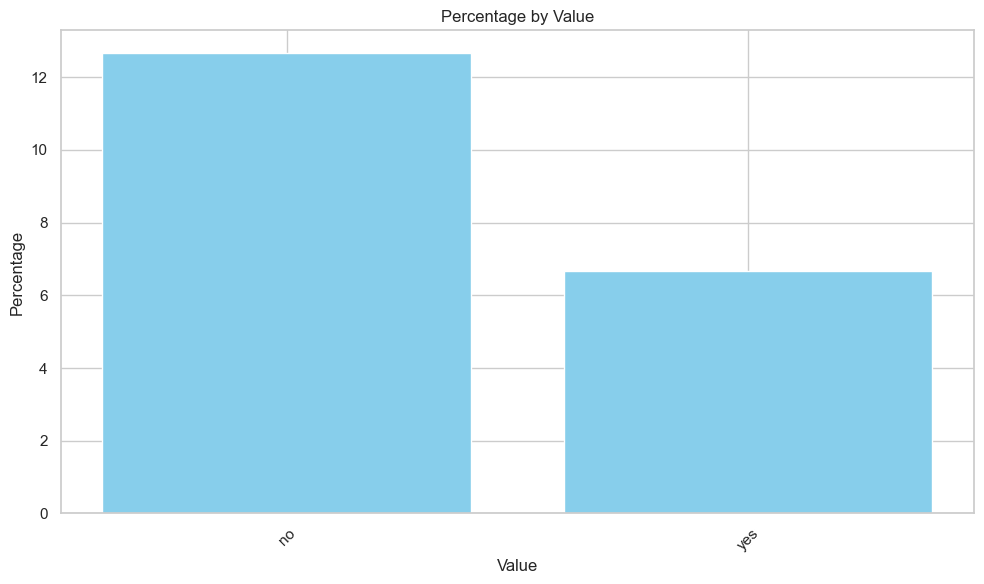

In [38]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(loan_df['Value'], loan_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [39]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in loan_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [40]:
# Wanted to further look at the distribution among each attribute
contact_df = result_df[result_df['Column'] == 'contact']
# Display table
contact_df

,Column,Value,Percentage,Total Frequency
26,contact,cellular,14.918900,29285
27,contact,telephone,13.420509,2906
25,contact,unknown,4.070661,13020


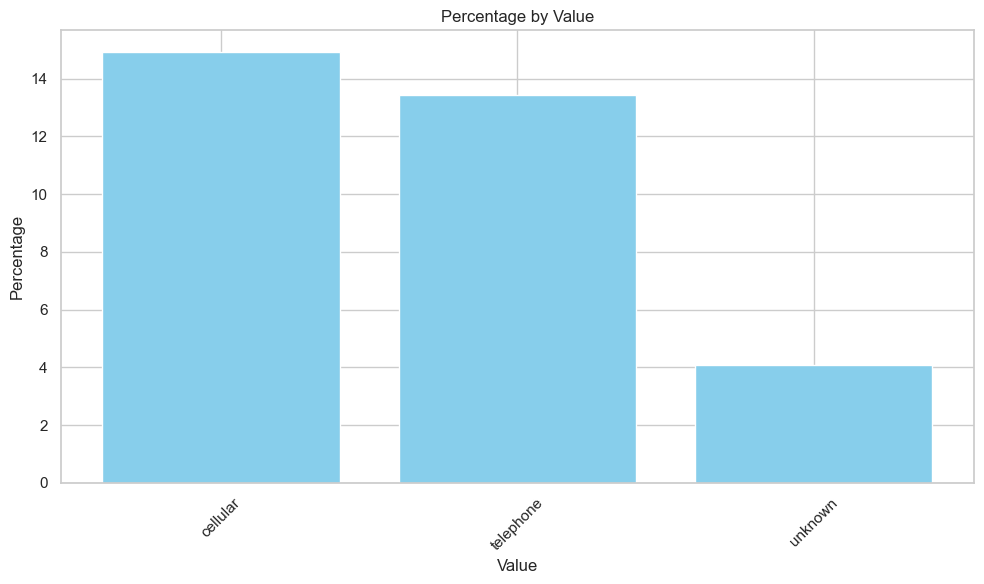

In [41]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(contact_df['Value'], contact_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [42]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in contact_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [43]:
# Wanted to further look at the distribution among each attribute
campaign_df = result_df[result_df['Column'] == 'campaign']
# Display table
campaign_df

,Column,Value,Percentage,Total Frequency
40,campaign,1,14.597583,17544
41,campaign,2,11.203519,12505
42,campaign,3,11.193624,5521
57,campaign,32,11.111111,9
44,campaign,4,9.000568,3522
61,campaign,17,8.695652,69
50,campaign,11,7.960199,201
43,campaign,5,7.879819,1764
45,campaign,6,7.126259,1291
48,campaign,9,6.422018,327


In [44]:
# Determine the min. freq. to display w/in table using 5%
campaign_cutoff = round(len(campaign_df) * .05, 0)
# Display the minimum amount of observations that a value needs to be included
print('Minumum observations for campaign results: ', campaign_cutoff)
# Display table
campaign_cutoff_df = campaign_df[campaign_df['Total Frequency'] > campaign_cutoff] 
# Print updated table
campaign_cutoff_df

Minumum observations for campaign results:  2.0


,Column,Value,Percentage,Total Frequency
40,campaign,1,14.597583,17544
41,campaign,2,11.203519,12505
42,campaign,3,11.193624,5521
57,campaign,32,11.111111,9
44,campaign,4,9.000568,3522
61,campaign,17,8.695652,69
50,campaign,11,7.960199,201
43,campaign,5,7.879819,1764
45,campaign,6,7.126259,1291
48,campaign,9,6.422018,327


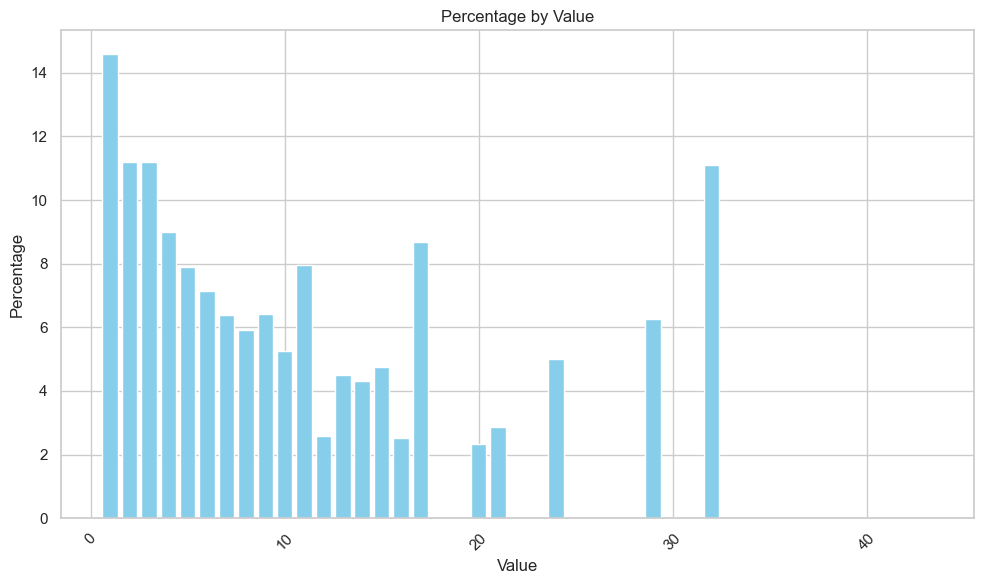

In [45]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(campaign_cutoff_df['Value'], campaign_cutoff_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [46]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in campaign_cutoff_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [47]:
# Wanted to further look at the distribution among each attribute
previous_df = result_df[result_df['Column'] == 'previous']
# Display table
previous_df

,Column,Value,Percentage,Total Frequency
126,previous,55,100.000000,1
122,previous,58,100.000000,1
106,previous,26,50.000000,2
97,previous,10,38.805970,67
121,previous,30,33.333333,3
103,previous,8,30.232558,129
95,previous,6,29.963899,277
96,previous,5,26.361656,459
99,previous,7,26.341463,205
104,previous,14,26.315789,19


In [48]:
# Establish min. freq. based on cutoff value of 5%
percentage_cutoff = round(len(previous_df) * .05, 0)
# Display the min. amount of freq.
print('Percent cutoff: ', percentage_cutoff)
# Create a subset accounting for cutoff
previous_cutoff_df = previous_df[previous_df['Total Frequency'] > percentage_cutoff]
# Display results
previous_cutoff_df

Percent cutoff:  2.0


,Column,Value,Percentage,Total Frequency
97,previous,10,38.805970,67
121,previous,30,33.333333,3
103,previous,8,30.232558,129
95,previous,6,29.963899,277
96,previous,5,26.361656,459
99,previous,7,26.341463,205
104,previous,14,26.315789,19
101,previous,9,26.086957,92
89,previous,3,25.744308,1142
102,previous,21,25.000000,4


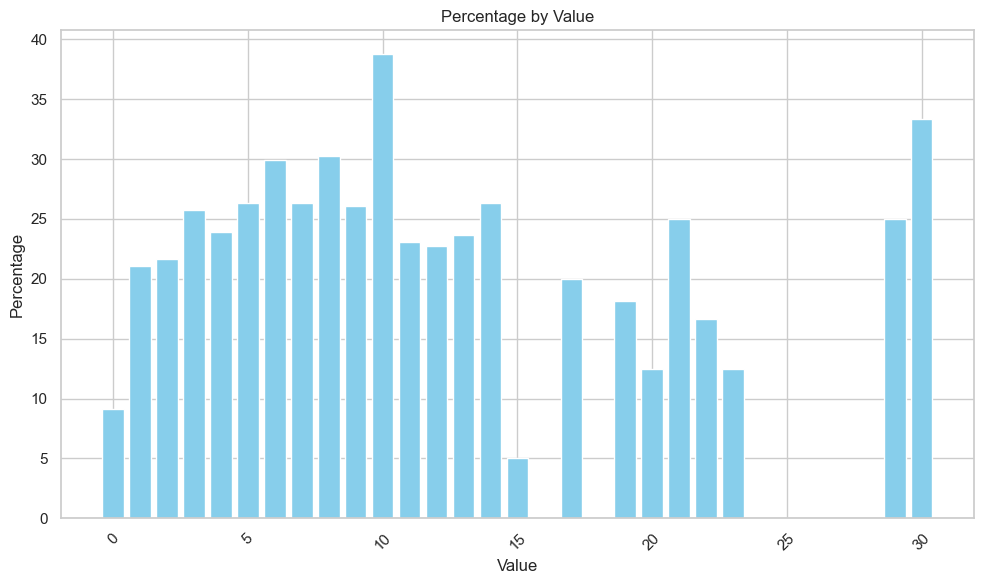

In [49]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(previous_cutoff_df['Value'], previous_cutoff_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [50]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in previous_cutoff_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


In [51]:
# Wanted to further look at the distribution among each attribute
poutcome_df = result_df[result_df['Column'] == 'poutcome']
# Display table
poutcome_df

,Column,Value,Percentage,Total Frequency
132,poutcome,success,64.725347,1511
131,poutcome,other,16.684783,1840
130,poutcome,failure,12.609671,4901
129,poutcome,unknown,9.161503,36959


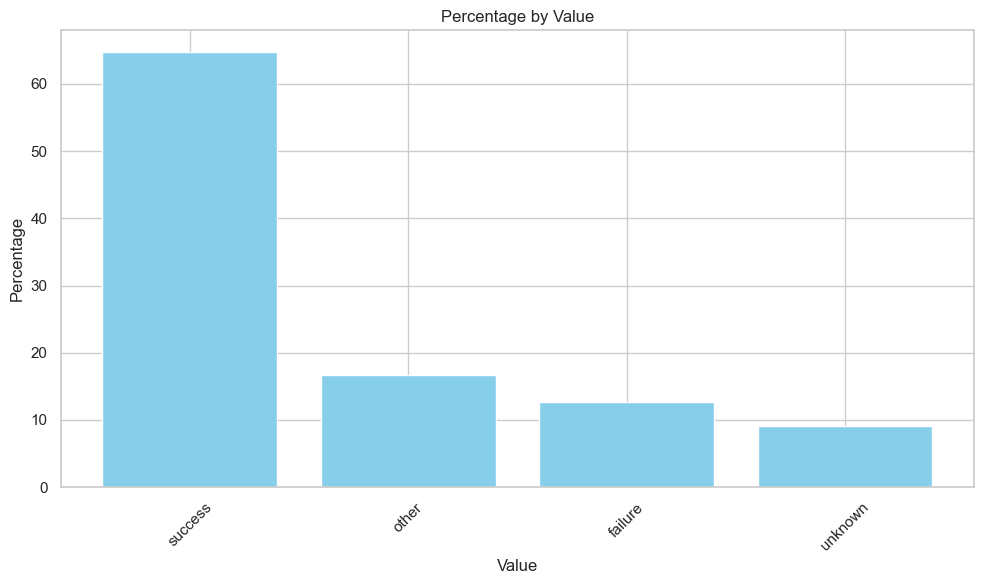

In [52]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(poutcome_df['Value'], poutcome_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [53]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in poutcome_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

There is no significant difference between the groups.


# Part 2 - Data Preprocessing

The portion was added in below, not sure if Jesse wanted to get rid of the knn stuff or the 3 cells above the knn code portion. I'll mark the code cells that I have questions on (Jess) 

Let's not include the knn chunks of code that I originally had attempted as I am not confident in the results since the recommended k value was 1 or 2 after implementing the elbow method

In [54]:
# replacing the -1 with 0 in the pdays variable
df['pdays'] = df['pdays'].replace(-1, 0)

## Split the dataset

In [55]:
# train (80%), validation (15%), test (5%) 
X = df.drop(columns=['y'])
y = df[['y']]
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.25, random_state=1)

In [56]:
# Display the dimensions of the data splits
print('The dimensions of the X train undersampled dataset is:', X_train.shape)
print('The dimensions of the Y train undersampled dataset is:', y_train.shape)
print('The dimensions of the X validation dataset is:', X_val.shape)
print('The dimensions of the Y validation dataset is:', y_val.shape)
print('The dimensions of the X test dataset is:', X_test.shape)
print('The dimensions of the Y test dataset is:', y_test.shape)

The dimensions of the X train undersampled dataset is: (36168, 16)
The dimensions of the Y train undersampled dataset is: (36168, 1)
The dimensions of the X validation dataset is: (6782, 16)
The dimensions of the Y validation dataset is: (6782, 1)
The dimensions of the X test dataset is: (2261, 16)
The dimensions of the Y test dataset is: (2261, 1)


In [57]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
22468,52,management,married,tertiary,no,0,no,no,cellular,22,aug,232,2,0,0,unknown
6896,50,admin.,single,secondary,no,330,yes,no,unknown,28,may,24,1,0,0,unknown
28408,45,blue-collar,married,primary,no,300,yes,no,cellular,29,jan,203,1,261,3,failure
8481,38,technician,married,secondary,no,27,yes,no,unknown,3,jun,404,4,0,0,unknown
28753,31,services,single,secondary,no,887,no,no,cellular,30,jan,427,1,0,0,unknown


In [58]:
# using the yeojohnson transformation because it can take both negative and postive numbers
X_train[num_vars] = X_train[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)
X_test[num_vars] = X_test[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)
X_val[num_vars] = X_val[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)

## Scaling

In [59]:
# Redefine cat_vars to not include the response variable
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Create pipelines for cat and num variables
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])
num_pipe = Pipeline([('standardize', StandardScaler())])

# Combine pipelines using ColumnTransformer
all_pipe = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_vars),
        ('num', num_pipe, num_vars)
    ],
    remainder='passthrough'
)

# Fit and transform the training data
X_train_trans = all_pipe.fit_transform(X_train)

# Get feature names for one-hot encoded cat variables
cat_encoder = all_pipe.named_transformers_['cat'].named_steps['encoder']
cat_encoder.fit(X_train[cat_vars])

# get cat feature names
cat_col_names = cat_encoder.get_feature_names_out(cat_vars)

# all feature names
all_col_names = list(cat_col_names) + num_vars

# Reassign the column names to the transformed datasets
X_train_trans = pd.DataFrame(X_train_trans, columns=all_col_names)
X_val_trans = pd.DataFrame(all_pipe.transform(X_val), columns=all_col_names)
X_test_trans = pd.DataFrame(all_pipe.transform(X_test), columns=all_col_names)


In [60]:
# Display preview of the results
X_train_trans.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.067420,-0.429147,0.767483,0.251846,0.127678,-0.471096,-0.471215
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.919258,-0.251638,1.376140,-1.952865,-1.112671,-0.471096,-0.471215
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.516420,-0.265243,1.473611,0.101383,-1.112671,2.134551,2.172014
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-0.144743,-0.407672,-1.690601,0.907102,1.086380,-0.471096,-0.471215
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.964915,-0.023747,1.570082,0.975265,-1.112671,-0.471096,-0.471215


In [61]:
# Review the datatype & null-values in the transformed train dataset
X_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_admin.           36168 non-null  float64
 1   job_blue-collar      36168 non-null  float64
 2   job_entrepreneur     36168 non-null  float64
 3   job_housemaid        36168 non-null  float64
 4   job_management       36168 non-null  float64
 5   job_retired          36168 non-null  float64
 6   job_self-employed    36168 non-null  float64
 7   job_services         36168 non-null  float64
 8   job_student          36168 non-null  float64
 9   job_technician       36168 non-null  float64
 10  job_unemployed       36168 non-null  float64
 11  job_unknown          36168 non-null  float64
 12  marital_divorced     36168 non-null  float64
 13  marital_married      36168 non-null  float64
 14  marital_single       36168 non-null  float64
 15  education_primary    36168 non-null 

In [62]:
## Convert 'no' to 0 and 'yes' to 1 in y_train
y_train['y'] = y_train['y'].map({'no': 0, 'yes': 1})

## Balancing

In [63]:
# Combine the transformed X_train and y_train into a single DataFrame
X_train_trans.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
balanced_train_data = pd.concat([X_train_trans, y_train], axis=1)

# Separate the majority (0) and minority (1) classes
major_class = balanced_train_data[balanced_train_data['y'] == 0]
minor_class = balanced_train_data[balanced_train_data['y'] == 1]

In [64]:
# Preview table
balanced_train_data.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.067420,-0.429147,0.767483,0.251846,0.127678,-0.471096,-0.471215,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.919258,-0.251638,1.376140,-1.952865,-1.112671,-0.471096,-0.471215,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.516420,-0.265243,1.473611,0.101383,-1.112671,2.134551,2.172014,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-0.144743,-0.407672,-1.690601,0.907102,1.086380,-0.471096,-0.471215,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,-0.964915,-0.023747,1.570082,0.975265,-1.112671,-0.471096,-0.471215,0


### Undersampling minority class

In [65]:
# Undersample the majority class to match the number of minority class samples
major_class_under = resample(major_class, replace=False, n_samples=len(minor_class), random_state=1)

# Combine the undersampled majority class with the minority class
train_data_under = pd.concat([major_class_under, minor_class])

# Separate the features (X) and the target (y) from the balanced training data
X_train_under = train_data_under.drop(columns=['y'])
y_train_under = train_data_under[['y']]

In [66]:
# Display the dimensions of the undersampled train dataset
print('The dimensions of the X train undersampled dataset is:', X_train_under.shape)
print('The dimensions of the Y train undersampled dataset is:', y_train_under.shape)
print('The dimensions of the X validation dataset is:', X_val.shape)
print('The dimensions of the Y validation dataset is:', y_val.shape)
print('The dimensions of the X test dataset is:', X_test.shape)
print('The dimensions of the Y test dataset is:', y_test.shape)

The dimensions of the X train undersampled dataset is: (8478, 51)
The dimensions of the Y train undersampled dataset is: (8478, 1)
The dimensions of the X validation dataset is: (6782, 16)
The dimensions of the Y validation dataset is: (6782, 1)
The dimensions of the X test dataset is: (2261, 16)
The dimensions of the Y test dataset is: (2261, 1)


In [67]:
# Display both dataframes
display(X_train_under.head())
display(y_train_under.head())

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
10630,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.710280,-0.428030,1.376140,-0.473390,0.127678,-0.471096,-0.471215
34302,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.516420,-0.241348,-0.374191,0.106872,-1.112671,2.137134,2.028412
23409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.099443,-0.238683,-1.047591,0.773472,-1.112671,2.135817,2.028412
12279,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.067420,-0.003636,0.221526,0.614515,-1.112671,-0.471096,-0.471215
20142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.041989,-0.418482,-0.009694,1.172383,0.127678,2.136911,2.152119


,y
10630,0
34302,0
23409,0
12279,0
20142,0


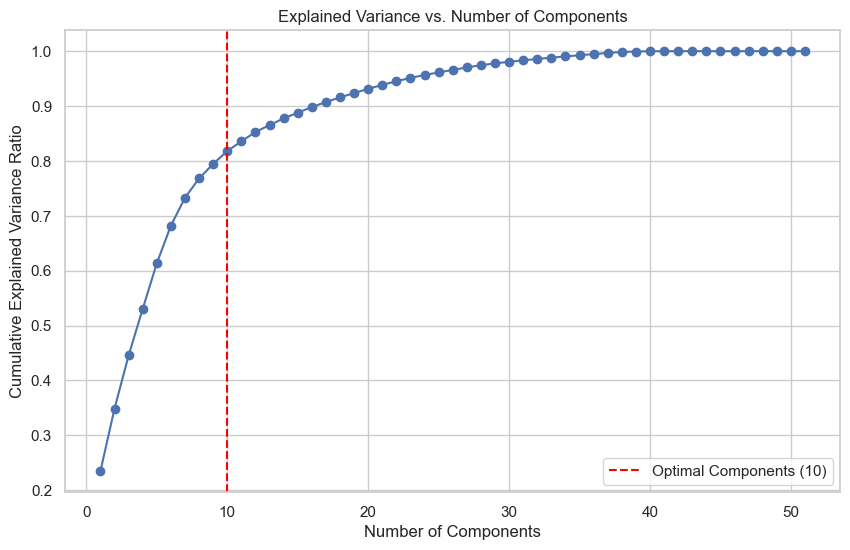

Optimal number of components: 10


In [68]:
# Initialize PCA with a large number of components
pca = PCA()

# Fit PCA on your scaled data
pca.fit(X_train_under)

# Plot the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.title("Explained Variance vs. Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)

# Determine the optimal number of components based on the plot
# You can choose a threshold (e.g., 0.95) and find the corresponding number of components
threshold = 0.8
optimal_num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

plt.axvline(x=optimal_num_components, color='red', linestyle='--', label=f'Optimal Components ({optimal_num_components})')
plt.legend()

plt.show()

print(f"Optimal number of components: {optimal_num_components}")

In [69]:
# I deemed 10 as the ideal number of components capturing >80% of cumulative explained variance
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train_under)

# Convert to a DataFrame from X_pca w/ original column names
pca_column_names = [f'PC{i}' for i in range(1, 11)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_column_names)

# Create a dictionary to map PCA column names to original
pca_to_original_mapping = {pca_column_names[i]: X_train_under.columns[i] for i in range(10)}  # Start from 0

# Use the mapping to match PCA component names to original columns
matching_columns = [pca_to_original_mapping[pca_col] for pca_col in X_pca_df.columns]

# Rename column names
X_pca_df.rename(columns=pca_to_original_mapping, inplace=True)

# Add 'y' column from df_factors_imputed to X_pca_df
X_pca_df['y'] = np.array(y_train_under)

# Display table
X_pca_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,y
0,-1.104894,-0.678300,-1.244557,0.694842,-0.168127,-0.777083,-0.560196,-0.953653,0.197807,-0.295659,0
1,2.879841,0.190022,-0.255985,-0.990676,-0.061672,-0.629934,0.930181,0.585449,-0.339536,0.351738,0
2,2.920528,-1.672375,0.813239,-0.706707,0.332589,-0.140564,0.746035,-0.188153,0.262799,-0.636918,0
3,-0.837178,0.985747,0.323759,-0.562124,-0.261234,-1.148959,0.478094,0.427936,-0.623082,-0.040564,0
4,2.805963,-0.808275,0.114998,-0.047054,-1.021549,0.296081,0.833110,-0.134613,0.551387,-0.866071,0


In [70]:
# Display the dimensions of the dataset
X_pca_df.shape

(8478, 11)

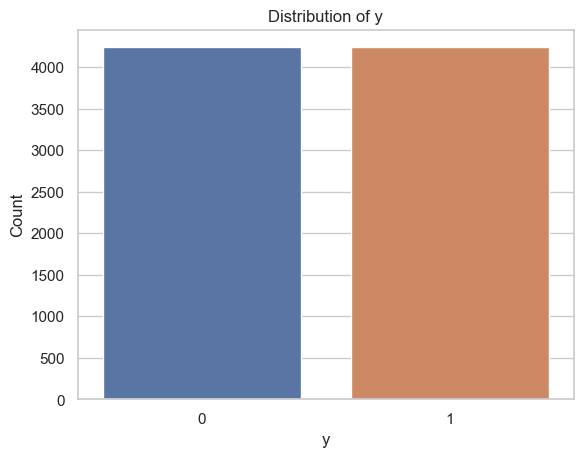

In [71]:
# Display distribution of response variable
sns.countplot(data=X_pca_df, x='y')
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Distribution of y')
plt.show()

## Model Development

### AdaBoost Model with oversampled data set

In [72]:
## Convert 'no' to 0 and 'yes' to 1 in y_val
y_val['y'] = y_val['y'].map({'no': 0, 'yes': 1})

In [73]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels 
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
learn_rate = [0.01,0.1]

# a grid for the randoms search to search through
random_grid = {'n_estimators': n_estimators,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               'learning_rate': learn_rate}


# spcifying the model
boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# searching through the hyperparamters with cv of 5
boost_random = RandomizedSearchCV(estimator = boost,
                               param_distributions = random_grid,
                               n_iter = 15, 
                               cv = 5, 
                               verbose=3, 
                               random_state=35, 
                               n_jobs = -1)

# fitting the model
boost_random.fit(X_train_under,y_train_under)

#getting the best hyper parameters
print(boost_random.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-v

[CV 1/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.844 total time=   3.5s
[CV 1/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=16;, score=0.850 total time=   3.7s
[CV 2/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.840 total time=   3.5s
[CV 2/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=16;, score=0.850 total time=   3.7s
[CV 5/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=16;, score=0.864 total time=   3.7s
[CV 4/5] END base_estimator__max_depth=40, base_estimator__min_samples_l

/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-v

[CV 1/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.826 total time=   0.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.814 total time=   0.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.825 total time=   0.3s
[CV 1/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.848 total time=   1.2s
[CV 2/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.844 total time=   1.3s
[CV 3/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.848 total time=   1.3s
[CV 5/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.844 total time=   1.3s
[CV 4/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3,

/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-v

[CV 4/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.818 total time=   0.4s
[CV 5/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.825 total time=   0.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.847 total time=   2.3s
[CV 1/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.837 total time=   0.6s
[CV 5/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.836 total time=   2.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.834 total time=   0.7s
[CV 3/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.834 total time=   0.7s
[CV 4/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.830 total time=   0.7s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.812 total time=   0.2s
[CV 2/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.804 total time=   0.2s
[CV 3/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.821 total time=   0.2s
[CV 4/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.815 total time=   0.2s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-v

[CV 5/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.841 total time=   0.7s
[CV 5/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.821 total time=   0.2s
[CV 3/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.847 total time=   2.5s
[CV 4/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.845 total time=   2.5s
[CV 1/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.838 total time=   2.6s
[CV 2/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4

/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-v

[CV 5/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.840 total time=   2.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.850 total time=   1.2s
[CV 2/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.837 total time=   1.2s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.843 total time=   1.2s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.853 total time=   2.5s
[CV 2/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.853 total time=   2.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.866 total time=   2.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.843 total time=   1.3s
[CV 5/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.867 total time=   2.6s
[CV 4/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.865 total time=   2.6s
[CV 5/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.841 total time=   1.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-v

[CV 1/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.838 total time=   1.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.840 total time=   1.6s
[CV 3/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.853 total time=   1.5s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.844 total time=   1.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.844 total time=   1.7s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.851 total time=   3.7s
[CV 2/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.837 total time=   3.7s
[CV 3/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.854 total time=   3.7s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.840 total time=   2.8s
[CV 2/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.838 total time=   2.8s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.856 total time=   2.7s
[CV 4/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.840 total time=   3.8s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.843 total time=   3.9s
[CV 1/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.840 total time=   1.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.844 total time=   1.4s
[CV 3/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.852 total time=   1.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.857 total time=   1.3s
[CV 4/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.844 total time=   1.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.844 total time=   1.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.846 total time=   1.5s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.845 total time=   3.1s
[CV 5/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.858 total time=   3.1s
[CV 3/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.861 total time=   1.5s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.863 total time=   1.6s
[CV 5/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.851 total time=   1.5s
[CV 1/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=17;, score=0.845 total time=   3.0s
[CV 2/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=17;, score=0.835 total time=   2.8s
[CV 3/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=17;, score=0.849 total time=   2.7s
[CV 4/5] END base_estimator__max_depth=80, base_estimator__min_samples_le

**Validation Data**

In [74]:
#X_val_new = X_val_trans[X_pca_df.columns]
y_val_pred = boost_random.predict(X_val_trans)

In [75]:
y_val

,y
9158,0
17388,0
23768,0
15345,0
16134,0
...,...
21826,0
31438,0
39482,0
32673,0


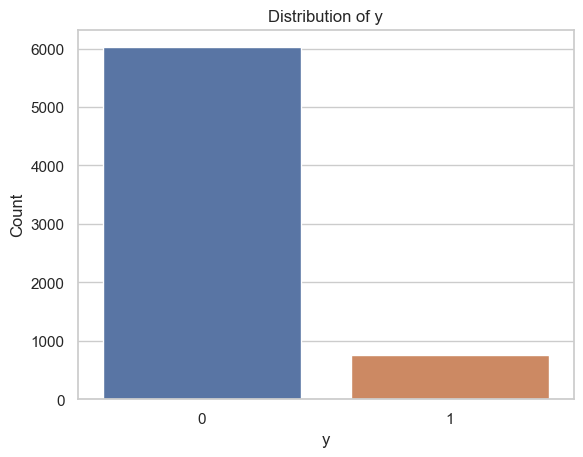

In [76]:
# Display distribution of predictor variable
sns.countplot(y_val['y'])
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Distribution of y')
plt.show()

Validation Accuracy: 0.7853140666470068
Confusion Matrix:
 [[4629 1393]
 [  63  697]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.86      6022
           1       0.33      0.92      0.49       760

    accuracy                           0.79      6782
   macro avg       0.66      0.84      0.68      6782
weighted avg       0.91      0.79      0.82      6782

ROC AUC Score: 0.9091451956859934


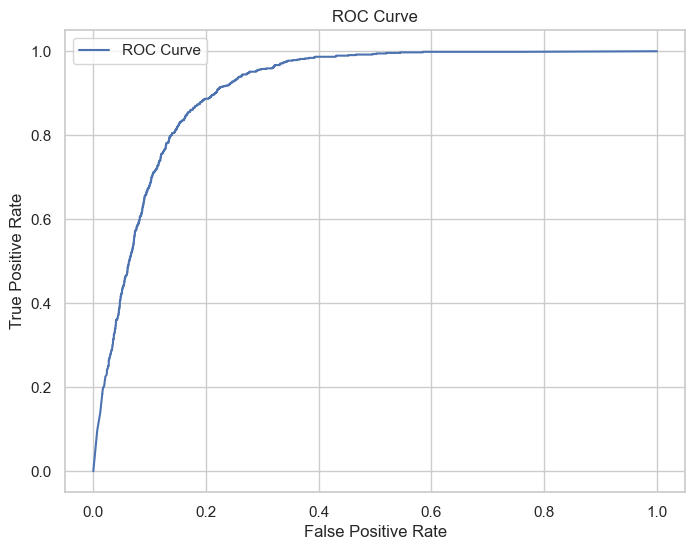

In [77]:
# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = boost_random.predict_proba(X_val_trans)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Test data set**

Validation Accuracy: 0.793454223794781
Confusion Matrix:
 [[1540  431]
 [  36  254]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      1971
           1       0.37      0.88      0.52       290

    accuracy                           0.79      2261
   macro avg       0.67      0.83      0.69      2261
weighted avg       0.90      0.79      0.82      2261

ROC AUC Score: 0.8934113612904354


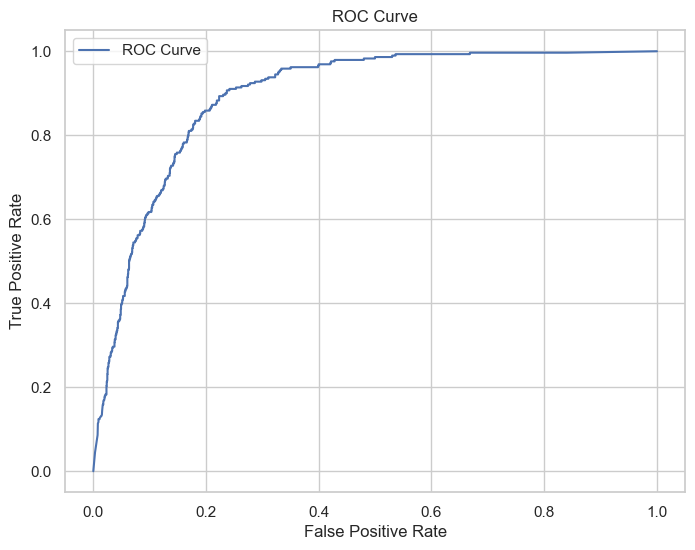

In [78]:
## Convert 'no' to 0 and 'yes' to 1 in y_test
y_test['y'] = y_test['y'].map({'no': 0, 'yes': 1})

#predicting values
y_test_pred = boost_random.predict(X_test_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = boost_random.predict_proba(X_test_trans)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### AdaBoost Model with original data set

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-v

[CV 3/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.905 total time=  15.9s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.898 total time=  16.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=16;, score=0.906 total time=  17.2s
[CV 4/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=16;, score=0.902 total time=  17.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.902 total time=  17.4s
[CV 1/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=16;, score=0.900 total time=  17.6s
[CV 5/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=16;, score=0.906 total time=  17.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=16;, score=0.903 total time=  17.8s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.889 total time=   3.0s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.895 total time=   2.7s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.890 total time=   2.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.897 total time=  10.0s
[CV 2/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.901 total time=   9.9s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.897 total time=  10.0s
[CV 3/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.899 total time=  10.2s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.902 total time=  10.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.888 total time=   2.9s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=100, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=2;, score=0.889 total time=   2.9s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.900 total time=  16.8s
[CV 4/5] END base_estimator__max_depth=30, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=12;, score=0.899 total time=  17.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.893 total time=   5.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.898 total time=   5.0s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.892 total time=   5.2s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.893 total time=   1.8s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.889 total time=   5.5s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.891 total time=   1.5s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.888 total time=   1.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.888 total time=   1.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=1;, score=0.885 total time=   1.4s
[CV 5/5] END base_estimator__max_depth=110, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=4;, score=0.891 total time=   5.9s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.901 total time=  20.9s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.904 total time=  21.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.899 total time=  21.9s
[CV 5/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.903 total time=  21.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=13;, score=0.899 total time=  23.5s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.893 total time=  10.5s
[CV 2/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.902 total time=  10.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.899 total time=  10.5s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.901 total time=  19.2s
[CV 2/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.904 total time=  18.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.903 total time=  19.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.901 total time=  19.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=17;, score=0.906 total time=  19.7s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.900 total time=  11.2s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=40, base_estimator__min_samples_leaf=3, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.901 total time=  11.8s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.899 total time=  12.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.897 total time=  13.5s
[CV 1/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.898 total time=  14.7s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.898 total time=  13.2s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=6, learning_rate=0.1, n_estimators=9;, score=0.898 total time=  11.8s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.893 total time=  16.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.902 total time=  17.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.900 total time=  18.5s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.899 total time=  37.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.902 total time=  35.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.899 total time=  10.2s
[CV 2/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.899 total time=  37.0s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.895 total time=  19.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.903 total time=  36.8s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=60, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=19;, score=0.899 total time=  38.5s
[CV 5/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=16;, score=0.900 total time=  19.4s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.899 total time=   9.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.899 total time=   9.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.899 total time=   9.2s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END base_estimator__max_depth=90, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=2, learning_rate=0.01, n_estimators=8;, score=0.902 total time=   9.6s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.901 total time=  10.3s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.901 total time=   9.8s


/Users/jesse/opt/anaconda3/envs/ADS502/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.898 total time=   9.9s
[CV 3/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.900 total time=  10.2s
[CV 5/5] END base_estimator__max_depth=120, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=10, learning_rate=0.01, n_estimators=9;, score=0.902 total time=   9.2s
[CV 3/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=17;, score=0.902 total time=  20.1s
[CV 2/5] END base_estimator__max_depth=80, base_estimator__min_samples_leaf=1, base_estimator__min_samples_split=10, learning_rate=0.1, n_estimators=17;, score=0.902 total time=  21.8s
[CV 1/5] END base_estimator__max_depth=80, base_estimator__min_samples_l

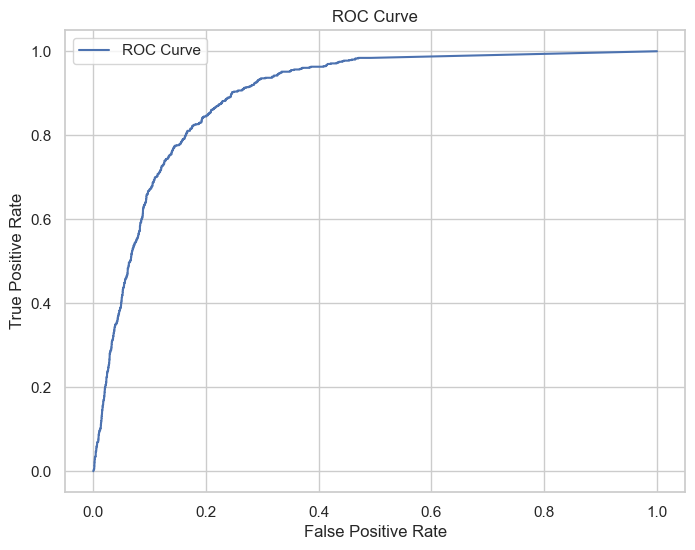

In [79]:
# fitting the model
boost_random.fit(X_train_trans,y_train)

#getting the best hyper parameters
print(boost_random.best_estimator_)

#predicting values
y_val_pred = boost_random.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = boost_random.predict_proba(X_val_trans)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Validation Accuracy: 0.8730650154798761
Confusion Matrix:
 [[1830  141]
 [ 146  144]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1971
           1       0.51      0.50      0.50       290

    accuracy                           0.87      2261
   macro avg       0.72      0.71      0.71      2261
weighted avg       0.87      0.87      0.87      2261

ROC AUC Score: 0.8708978463584038


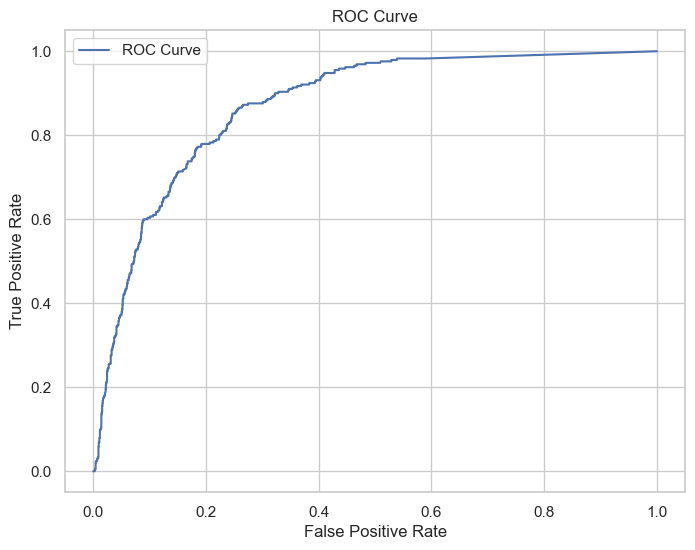

In [80]:
#predicting values
y_test_pred = boost_random.predict(X_test_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = boost_random.predict_proba(X_test_trans)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Logistic Regression with over sampled training data

In [81]:
# building the model for the over sampled training data
logreg_over = LogisticRegressionCV(solver = 'lbfgs', cv = 5, max_iter = 500).fit(X_train_under,y_train_under)

# coefficients for the model
coeff_over = pd.DataFrame({'coeff': logreg_over.coef_[ 0], 'abs_coeff': np.abs(logreg_over.coef_[0])}, index = X_train_under.columns)
print(coeff_over.sort_values(by = ['abs_coeff'], ascending = False))

                        coeff  abs_coeff
month_mar            1.955744   1.955744
duration             1.821000   1.821000
month_oct            1.587737   1.587737
poutcome_success     1.367259   1.367259
month_jan           -1.255588   1.255588
month_jul           -1.108745   1.108745
month_nov           -0.945595   0.945595
contact_unknown     -0.898063   0.898063
month_aug           -0.861051   0.861051
job_student          0.803345   0.803345
month_may           -0.716765   0.716765
poutcome_failure    -0.706552   0.706552
month_sep            0.686066   0.686066
poutcome_other      -0.679330   0.679330
previous             0.662377   0.662377
month_dec            0.564964   0.564964
job_retired          0.549122   0.549122
contact_telephone    0.457328   0.457328
contact_cellular     0.442631   0.442631
job_unknown         -0.437561   0.437561
housing_no           0.406531   0.406531
housing_yes         -0.404636   0.404636
job_self-employed   -0.362672   0.362672
job_blue-collar 

**Validation Data**

Validation Accuracy: 0.8003538779121203
Confusion Matrix:
 [[4763 1259]
 [  95  665]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.88      6022
           1       0.35      0.88      0.50       760

    accuracy                           0.80      6782
   macro avg       0.66      0.83      0.69      6782
weighted avg       0.91      0.80      0.83      6782

ROC AUC Score: 0.9126741421804262


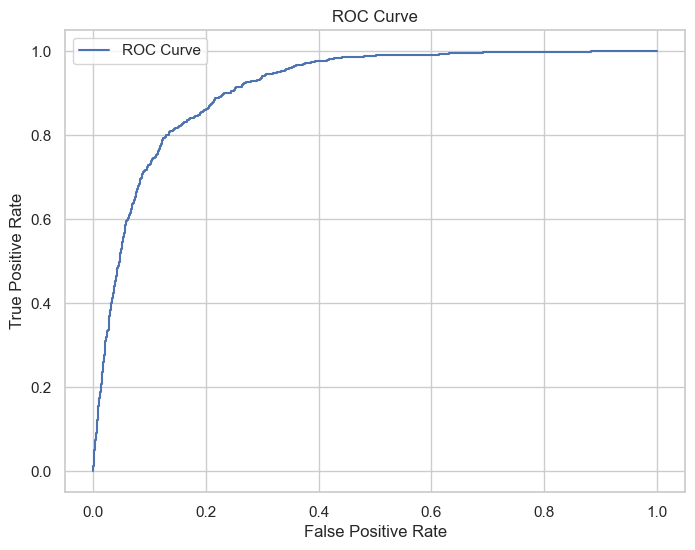

In [82]:
#log reg prediction
y_val_pred = logreg_over.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = logreg_over.predict_proba(X_val_trans)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Test Data**

Validation Accuracy: 0.8058381247235736
Confusion Matrix:
 [[1592  379]
 [  60  230]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      1971
           1       0.38      0.79      0.51       290

    accuracy                           0.81      2261
   macro avg       0.67      0.80      0.70      2261
weighted avg       0.89      0.81      0.83      2261

ROC AUC Score: 0.8887909165660699


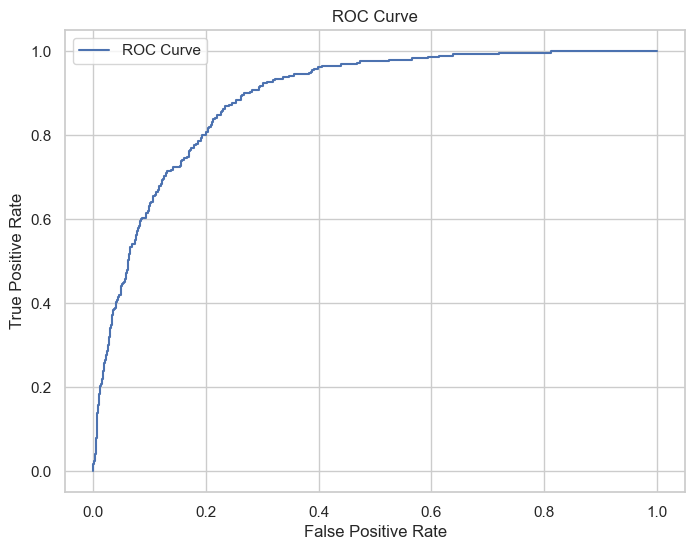

In [83]:
#log reg prediction for test data
y_test_pred = logreg_over.predict(X_test_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = logreg_over.predict_proba(X_test_trans)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Logistic Regression with original training data

In [84]:
# building a model with our original training data
logreg_orig = LogisticRegressionCV(solver = 'lbfgs', cv = 5, max_iter = 500, class_weight='balanced').fit(X_train_trans,y_train)

# coefficients for the model
coeff_orig = pd.DataFrame({'coeff': logreg_orig.coef_[ 0], 'abs_coeff': np.abs(logreg_orig.coef_[0])}, index = X_train_trans.columns)
print(coeff_orig.sort_values(by = ['abs_coeff'], ascending = False))

                        coeff  abs_coeff
month_mar            2.013252   2.013252
duration             1.814080   1.814080
previous             1.506392   1.506392
month_jan           -1.457031   1.457031
month_oct            1.387039   1.387039
poutcome_success     1.213332   1.213332
poutcome_failure    -1.162326   1.162326
month_jul           -1.113200   1.113200
poutcome_other      -1.020590   1.020590
contact_unknown     -1.020049   1.020049
month_nov           -1.001150   1.001150
month_sep            0.986891   0.986891
month_aug           -0.888306   0.888306
poutcome_unknown     0.811912   0.811912
month_may           -0.791478   0.791478
job_student          0.708725   0.708725
month_dec            0.652999   0.652999
pdays               -0.631113   0.631113
job_retired          0.571747   0.571747
housing_yes         -0.459182   0.459182
contact_telephone    0.445209   0.445209
contact_cellular     0.417169   0.417169
job_unknown         -0.367099   0.367099
job_self-employe

**Validation Data**

Validation Accuracy: 0.8015334709525214
Confusion Matrix:
 [[4770 1252]
 [  94  666]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.88      6022
           1       0.35      0.88      0.50       760

    accuracy                           0.80      6782
   macro avg       0.66      0.83      0.69      6782
weighted avg       0.91      0.80      0.83      6782

ROC AUC Score: 0.9126741421804262


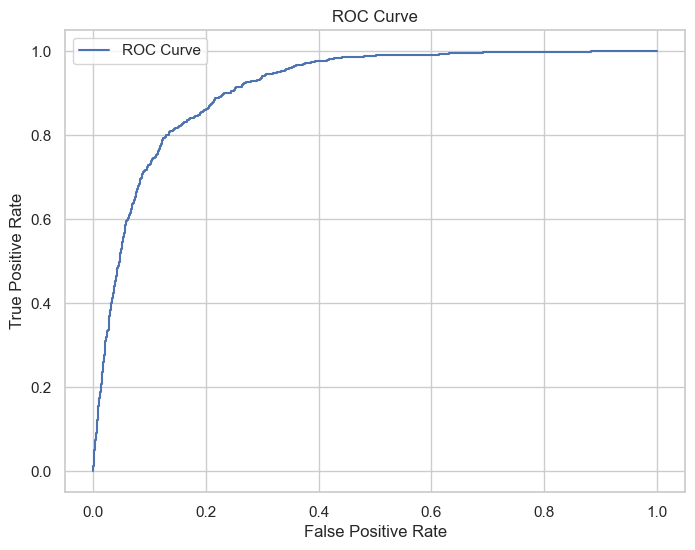

In [85]:
#log reg prediction
y_val_pred = logreg_orig.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = logreg_over.predict_proba(X_val_trans)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Testing Data**

Validation Accuracy: 0.8022998673153472
Confusion Matrix:
 [[1584  387]
 [  60  230]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.80      0.88      1971
           1       0.37      0.79      0.51       290

    accuracy                           0.80      2261
   macro avg       0.67      0.80      0.69      2261
weighted avg       0.89      0.80      0.83      2261

ROC AUC Score: 0.8887909165660699


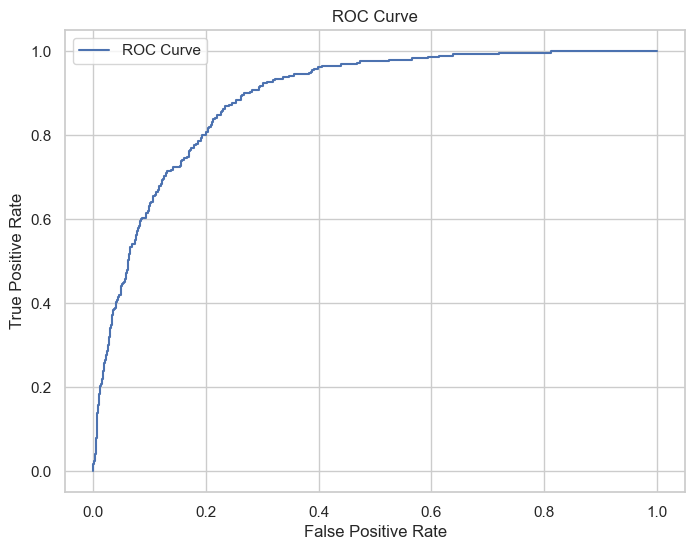

In [86]:
#log reg prediction for test data
y_test_pred = logreg_orig.predict(X_test_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = logreg_over.predict_proba(X_test_trans)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### K Nearest Neighbors

**KNN With Oversampled Dataset**

In [87]:
# using grid search to find the best k
# inertia = []
# mapping = {}
# K = range(1, 10)
 
# for k in K:
    # Building and fitting the model
  #   kmeanModel = KMeans(n_clusters=k).fit(X_train_under,y_train_under)
  #   inertia.append(kmeanModel.inertia_)
  #   mapping[k] = kmeanModel.inertia_
    
    
# plotting the elbow curve

# for key, val in mapping.items():
  #   print(f'{key} : {val}')
    
# plt.plot(K, inertia, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Inertia')
# plt.title('The Elbow Method using Inertia')
# plt.show()

In [88]:
# knn model
# knn_over = KNeighborsClassifier(n_neighbors = 2).fit(X_train_under,y_train_under)

**Validation Data**

In [89]:
#knn prediction
# y_val_pred = knn_over.predict(X_val_trans)

# Calculate accuracy on the validation set
# accuracy = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy:", accuracy)

# Display confusion matrix
# confusion = confusion_matrix(y_val, y_val_pred)
# print("Confusion Matrix:\n", confusion)

# Conduct classification report
# report = classification_report(y_val, y_val_pred)
# print("Classification Report:\n", report)

# Calculate ROC AUC
# y_prob = knn_over.predict_proba(X_val_trans)[:, 1]
# roc_auc = roc_auc_score(y_val, y_prob)
# print("ROC AUC Score:", roc_auc)

# Generate ROC curve
# fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

**Test Data**

In [90]:
#log reg prediction for test data
# y_test_pred = knn_over.predict(X_test_trans)

# Calculate accuracy on the validation set
# accuracy = accuracy_score(y_test, y_test_pred)
# print("Validation Accuracy:", accuracy)

# Display confusion matrix
# confusion = confusion_matrix(y_test, y_test_pred)
# print("Confusion Matrix:\n", confusion)

# Conduct classification report
# report = classification_report(y_test, y_test_pred)
# print("Classification Report:\n", report)

# Calculate ROC AUC
# y_prob = knn_over.predict_proba(X_test_trans)[:, 1]
# roc_auc = roc_auc_score(y_test, y_prob)
# print("ROC AUC Score:", roc_auc)

# Generate ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

### KNN with originial training data set

In [91]:
# using grid search to find the best k
# inertia = []
# mapping = {}
# K = range(1, 10)
 
# for k in K:
  #   # Building and fitting the model
  #   kmeanModel = KMeans(n_clusters=k).fit(X_train_trans, y_train)
  #   inertia.append(kmeanModel.inertia_)
  #   mapping[k] = kmeanModel.inertia_
    
# plotting the elbow curve
# for key, val in mapping.items():
  #   print(f'{key} : {val}')
    
# plt.plot(K, inertia, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Inertia')
# plt.title('The Elbow Method using Inertia')
# plt.show()

In [92]:
# knn model
# knn_orig = KNeighborsClassifier(n_neighbors = 2).fit(X_train_trans,y_train)

**Validation Data**

In [93]:
#knn prediction
# y_val_pred = knn_orig.predict(X_val_trans)

# Calculate accuracy on the validation set
# accuracy = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy:", accuracy)

# Display confusion matrix
# confusion = confusion_matrix(y_val, y_val_pred)
# print("Confusion Matrix:\n", confusion)

# Conduct classification report
# report = classification_report(y_val, y_val_pred)
# print("Classification Report:\n", report)

# Calculate ROC AUC
# y_prob = knn_orig.predict_proba(X_val_trans)[:, 1]
# roc_auc = roc_auc_score(y_val, y_prob)
# print("ROC AUC Score:", roc_auc)

# Generate ROC curve
# fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

**Test Data**

In [94]:
#log reg prediction for test data
# y_test_pred = knn_orig.predict(X_test_trans)

# Calculate accuracy on the validation set
# accuracy = accuracy_score(y_test, y_test_pred)
# print("Validation Accuracy:", accuracy)

# Display confusion matrix
# confusion = confusion_matrix(y_test, y_test_pred)
# print("Confusion Matrix:\n", confusion)

# Conduct classification report
# report = classification_report(y_test, y_test_pred)
# print("Classification Report:\n", report)

# Calculate ROC AUC
# y_prob = knn_orig.predict_proba(X_test_trans)[:, 1]
# roc_auc = roc_auc_score(y_test, y_prob)
# print("ROC AUC Score:", roc_auc)

# Generate ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

## Neural Network

### Validation Dataset

Validation Accuracy (Neural Network): 0.875552934237688
Confusion Matrix (Neural Network):
 [[5522  500]
 [ 344  416]]
Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      6022
           1       0.45      0.55      0.50       760

    accuracy                           0.88      6782
   macro avg       0.70      0.73      0.71      6782
weighted avg       0.89      0.88      0.88      6782

ROC AUC Score (Neural Network): 0.8807475659424217


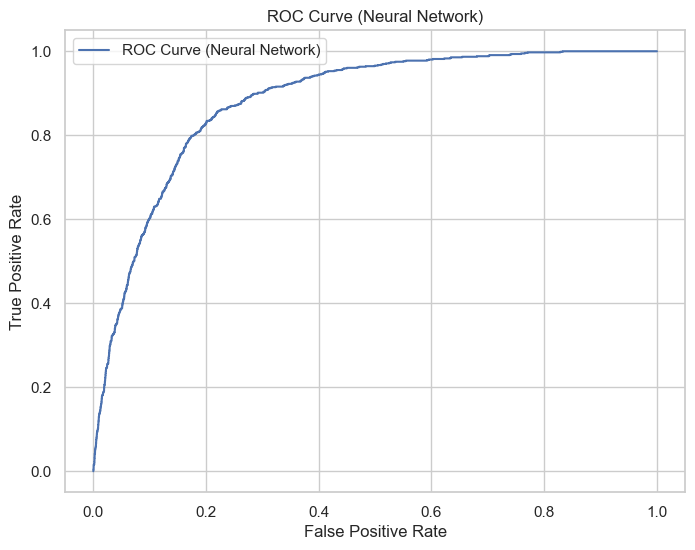

In [95]:
from sklearn.neural_network import MLPClassifier

# Create and train a Neural Network model
neural_network = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
neural_network.fit(X_train_trans, y_train)

# Predict values on the validation set
y_val_pred_nn = neural_network.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy_nn = accuracy_score(y_val, y_val_pred_nn)
print("Validation Accuracy (Neural Network):", accuracy_nn)

# Display confusion matrix
confusion_nn = confusion_matrix(y_val, y_val_pred_nn)
print("Confusion Matrix (Neural Network):\n", confusion_nn)

# Conduct classification report
report_nn = classification_report(y_val, y_val_pred_nn)
print("Classification Report (Neural Network):\n", report_nn)

# Calculate ROC AUC
y_prob_nn = neural_network.predict_proba(X_val_trans)[:, 1]
roc_auc_nn = roc_auc_score(y_val, y_prob_nn)
print("ROC AUC Score (Neural Network):", roc_auc_nn)

# Generate ROC curve
fpr_nn, tpr_nn, _ = roc_curve(y_val, y_prob_nn)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label="ROC Curve (Neural Network)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Neural Network)")
plt.legend()
plt.show()

### Testing Dataset

Test Accuracy (Neural Network): 0.8637770897832817
Confusion Matrix (Neural Network):
 [[1826  145]
 [ 163  127]]
Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1971
           1       0.47      0.44      0.45       290

    accuracy                           0.86      2261
   macro avg       0.69      0.68      0.69      2261
weighted avg       0.86      0.86      0.86      2261

ROC AUC Score (Neural Network): 0.8584754806767089


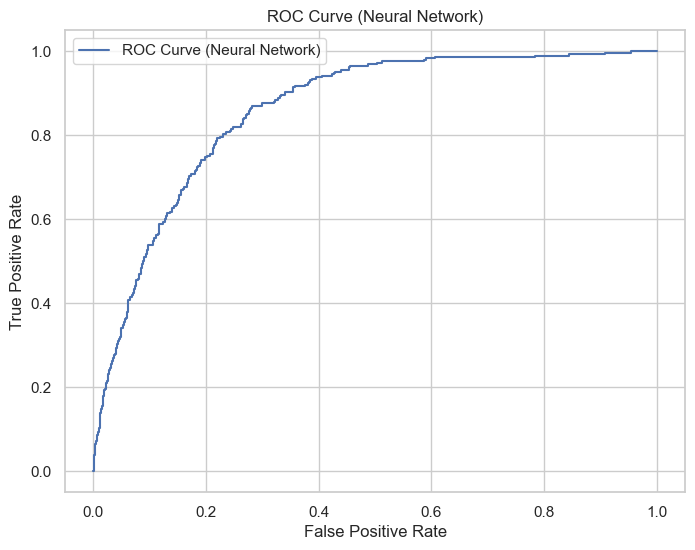

In [96]:
from sklearn.neural_network import MLPClassifier

# Create and train a Neural Network model
neural_network = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=35)
neural_network.fit(X_train_trans, y_train)

# Predict values on the test set
y_test_pred_nn = neural_network.predict(X_test_trans)

# Calculate accuracy on the test set
accuracy_nn = accuracy_score(y_test, y_test_pred_nn)
print("Test Accuracy (Neural Network):", accuracy_nn)

# Display confusion matrix
confusion_nn = confusion_matrix(y_test, y_test_pred_nn)
print("Confusion Matrix (Neural Network):\n", confusion_nn)

# Conduct classification report
report_nn = classification_report(y_test, y_test_pred_nn)
print("Classification Report (Neural Network):\n", report_nn)

# Calculate ROC AUC
y_prob_nn = neural_network.predict_proba(X_test_trans)[:, 1]
roc_auc_nn = roc_auc_score(y_test, y_prob_nn)
print("ROC AUC Score (Neural Network):", roc_auc_nn)

# Generate ROC curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label="ROC Curve (Neural Network)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Neural Network)")
plt.legend()
plt.show()

## Random Forest

### Validation Dataset

Validation Accuracy (Random Forest): 0.8961958124447066
Confusion Matrix (Random Forest):
 [[5706  316]
 [ 388  372]]
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      6022
           1       0.54      0.49      0.51       760

    accuracy                           0.90      6782
   macro avg       0.74      0.72      0.73      6782
weighted avg       0.89      0.90      0.89      6782

ROC AUC Score (Random Forest): 0.9091128581167299


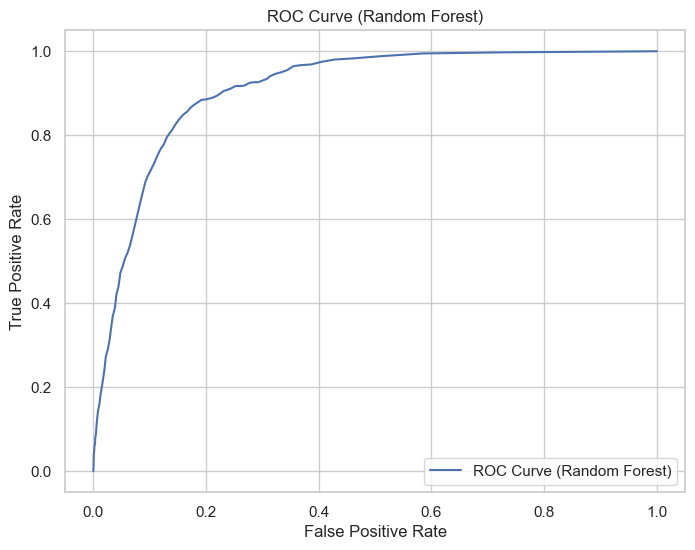

In [97]:
from sklearn.ensemble import RandomForestClassifier

# Create and train a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=35)
random_forest.fit(X_train_trans, y_train)

# Predict values on the validation set
y_val_pred_rf = random_forest.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print("Validation Accuracy (Random Forest):", accuracy_rf)

# Display confusion matrix
confusion_rf = confusion_matrix(y_val, y_val_pred_rf)
print("Confusion Matrix (Random Forest):\n", confusion_rf)

# Conduct classification report
report_rf = classification_report(y_val, y_val_pred_rf)
print("Classification Report (Random Forest):\n", report_rf)

# Calculate ROC AUC
y_prob_rf = random_forest.predict_proba(X_val_trans)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_prob_rf)
print("ROC AUC Score (Random Forest):", roc_auc_rf)

# Generate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label="ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()

### Testing Dataset

Validation Accuracy (Random Forest): 0.8961958124447066
Confusion Matrix (Random Forest):
 [[5706  316]
 [ 388  372]]
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      6022
           1       0.54      0.49      0.51       760

    accuracy                           0.90      6782
   macro avg       0.74      0.72      0.73      6782
weighted avg       0.89      0.90      0.89      6782

ROC AUC Score (Random Forest): 0.9091128581167299


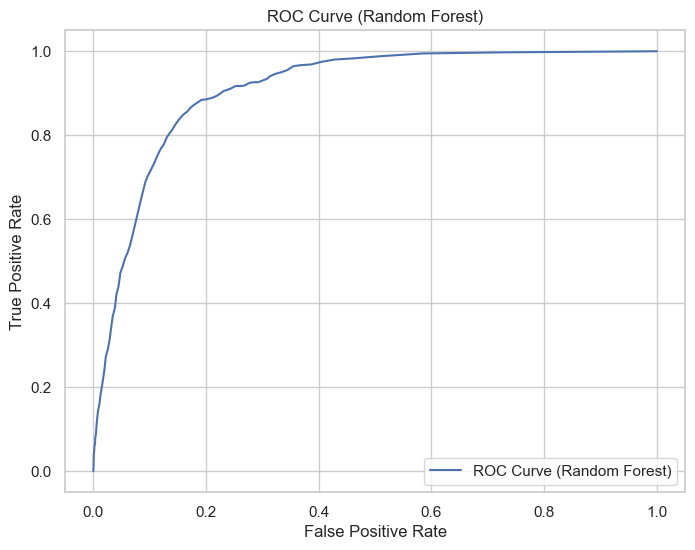

In [98]:
from sklearn.ensemble import RandomForestClassifier

# Create and train a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=35)
random_forest.fit(X_train_trans, y_train)

# Predict values on the validation set
y_val_pred_rf = random_forest.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print("Validation Accuracy (Random Forest):", accuracy_rf)

# Display confusion matrix
confusion_rf = confusion_matrix(y_val, y_val_pred_rf)
print("Confusion Matrix (Random Forest):\n", confusion_rf)

# Conduct classification report
report_rf = classification_report(y_val, y_val_pred_rf)
print("Classification Report (Random Forest):\n", report_rf)

# Calculate ROC AUC
y_prob_rf = random_forest.predict_proba(X_val_trans)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_prob_rf)
print("ROC AUC Score (Random Forest):", roc_auc_rf)

# Generate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label="ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()

## Support Vector Machine

### Validation Dataset

Test Accuracy (SVM): 0.8929677134011499
Confusion Matrix (SVM):
 [[1933   38]
 [ 204   86]]
Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1971
           1       0.69      0.30      0.42       290

    accuracy                           0.89      2261
   macro avg       0.80      0.64      0.68      2261
weighted avg       0.88      0.89      0.87      2261

ROC AUC Score (SVM): 0.8989065588971116


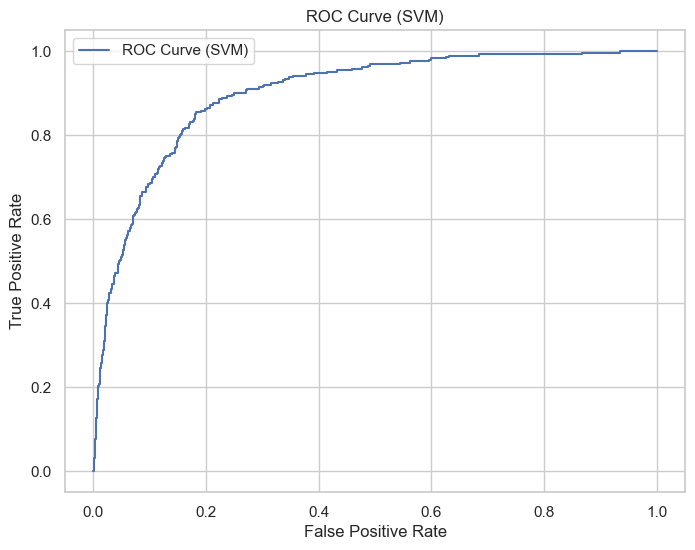

In [102]:
from sklearn.svm import SVC

# Create and train a Support Vector Machine (SVM) model
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train_trans, y_train)

# Predict values on the validation set
y_test_pred_svm = svm_classifier.predict(X_test_trans)


# Calculate accuracy on the test set
accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print("Test Accuracy (SVM):", accuracy_svm)

# Display confusion matrix
confusion_svm = confusion_matrix(y_test, y_test_pred_svm)
print("Confusion Matrix (SVM):\n", confusion_svm)

# Conduct classification report
report_svm = classification_report(y_test, y_test_pred_svm)
print("Classification Report (SVM):\n", report_svm)

# Calculate ROC AUC
y_prob_svm = svm_classifier.predict_proba(X_test_trans)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
print("ROC AUC Score (SVM):", roc_auc_svm)

# Generate ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label="ROC Curve (SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM)")
plt.legend()
plt.show()